Import vital libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
%matplotlib inline
from matplotlib import pyplot as plt
from optbinning import Scorecard, BinningProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

(CVXPY) Jun 04 09:34:57 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 04 09:34:57 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


Load customer data from xslx file

In [201]:
dulieuktl = dulieuktl.drop(['ListedOnUTC', 'BiddingStartedOn', 'BidsManual', 'PartyId',
       'LoanApplicationStartedDate', 'FirstPaymentDate',
        'LastPaymentOn', 'RecoveryStage', 'ApplicationSignedHour','ApplicationSignedWeekday','DateOfBirth','GracePeriodStart','GracePeriodEnd',
       'StageActiveSince', 'PrincipalBalance',
       'InterestAndPenaltyBalance', 'NextPaymentNr',
       'NrOfScheduledPayments','ReportAsOfEOD','LoanId','LoanNumber','BidsPortfolioManager','BidsApi','LoanDate','ContractEndDate','MaturityDate_Last'],axis =1)

In [ ]:
dulieuktl.to_excel("C:/Users/HANG/Downloads/LoanDataVPBank.xlsx")

In [ ]:
dulieuktl = pd.read_csv("C:/Users/HANG/Downloads/LoanDataVPBank.xlsx")

The A-score model for home loan is built based on Good/Bad statistical analysis using logistic regression. The model is designed as a scorecard.This process includes stages as follows:
1. Data cleaning;
2. Single factor analysis;
3. Variables transformation;
4. Multiple factor analysis;
5. Model validation.

In real-world context, more steps are necessary to be done and they are more complicated too. That is, at first preparing the long list of variables and especially the stage of collecting, preparing data and process them before using is very time-consuming; and after all, there will be pooling and PD calibration steps. However, due to the lack of time and knowledge, I am just able to guide you through my process as listed above.

1. Data cleaning

In [206]:
dulieuktl.shape

(307308, 86)

My model building sample has 307308 observations, and I have an available list of 46 characteristics of customers. These potential charactistics are supposed to be meaningful in real business (i.e evident to affect the default probability of customers).

* Checking if there is any duplicated observation; missing, illogical value or outlier from each column

I did check it and array of duplicated rows looks way too ugly so I will not show here

In [209]:
dulieuktlNew = dulieuktl.drop_duplicates()

In [214]:
dulieuktlNew[dulieuktlNew.duplicated()]

Empty DataFrame
Columns: [NewCreditCustomer, MaturityDate_Original, VerificationType, LanguageCode, Age, Gender, Country, AppliedAmount, Amount, Interest, LoanDuration, MonthlyPayment, County, City, UseOfLoan, Education, MaritalStatus, NrOfDependants, EmploymentStatus, EmploymentDurationCurrentEmployer, EmploymentPosition, WorkExperience, OccupationArea, HomeOwnershipType, IncomeFromPrincipalEmployer, IncomeFromPension, IncomeFromFamilyAllowance, IncomeFromSocialWelfare, IncomeFromLeavePay, IncomeFromChildSupport, IncomeOther, IncomeTotal, ExistingLiabilities, LiabilitiesTotal, RefinanceLiabilities, DebtToIncome, FreeCash, MonthlyPaymentDay, ActiveScheduleFirstPaymentReached, PlannedPrincipalTillDate, PlannedInterestTillDate, CurrentDebtDaysPrimary, DebtOccuredOn, CurrentDebtDaysSecondary, DebtOccuredOnForSecondary, ExpectedLoss, LossGivenDefault, ExpectedReturn, ProbabilityOfDefault, DefaultDate, PrincipalOverdueBySchedule, PlannedPrincipalPostDefault, PlannedInterestPostDefault, EAD1, EAD2, PrincipalRecovery, InterestRecovery, ModelVersion, Rating, EL_V0, Rating_V0, EL_V1, Rating_V1, Rating_V2, Status, Restructured, ActiveLateCategory, WorseLateCategory, CreditScoreEsMicroL, CreditScoreEsEquifaxRisk, CreditScoreFiAsiakasTietoRiskGrade, CreditScoreEeMini, PrincipalPaymentsMade, InterestAndPenaltyPaymentsMade, PrincipalWriteOffs, InterestAndPenaltyWriteOffs, NoOfPreviousLoansBeforeLoan, AmountOfPreviousLoansBeforeLoan, PreviousRepaymentsBeforeLoan, PreviousEarlyRepaymentsBefoleLoan, PreviousEarlyRepaymentsCountBeforeLoan, NextPaymentDate, ReScheduledOn, PrincipalDebtServicingCost, InterestAndPenaltyDebtServicingCost, ActiveLateLastPaymentCategory]
Index: []

[0 rows x 86 columns]

In [217]:
dulieuktlNew.loc[:, dulieuktlNew.columns!='Status'].isnull().sum()

NewCreditCustomer                           0
MaturityDate_Original                       0
VerificationType                           50
LanguageCode                                0
Age                                         0
                                        ...  
NextPaymentDate                        189199
ReScheduledOn                          189508
PrincipalDebtServicingCost             206316
InterestAndPenaltyDebtServicingCost    206316
ActiveLateLastPaymentCategory          184185
Length: 85, dtype: int64

In [218]:
dulieuktlNew.loc[:, dulieuktlNew.columns!='Status'].eq(0).sum()

NewCreditCustomer                      140248
MaturityDate_Original                       0
VerificationType                            8
LanguageCode                                0
Age                                        48
                                        ...  
NextPaymentDate                             0
ReScheduledOn                               0
PrincipalDebtServicingCost              95059
InterestAndPenaltyDebtServicingCost     36102
ActiveLateLastPaymentCategory               0
Length: 85, dtype: int64

In [8]:
#Sollution:

+ Missing values:
-Exclude all data with missing values—this is complete case analysis, and in most financial industry cases, will likely result in very little data to work with;
-Exclude records that have significant (e.g.more than 50%) missing values from the model, especially if the level of missing is expected to continue in the future;
-Include characteristics with missing values in the scorecard. The “missing” can then be treated as a separate attribute, grouped, and used in regression as an input. The scorecard can then be allowed to assign weights to this attribute. In some cases this assigned weight may be close to the “neutral” or mean value, but in cases where the weight is closer to another attribute, it may shed light on the exact nature of the missing values;
-Impute missing values using statistical techniques.

* Discard variables having > 50% Nan or 0 value

In [219]:
df = dulieuktlNew.loc[:, dulieuktlNew.columns!='y'].isnull().sum()/len(dulieuktlNew.index)

In [220]:
df1 = dulieuktlNew.loc[:, dulieuktlNew.columns!='y'].eq(0).sum()/len(dulieuktlNew.index)

In [221]:
df2 = pd.DataFrame({'variable':df.index, 'rate_isnull':df.values, 'rate_eqzero': df1.values})

In [222]:
df2

variable  rate_isnull  rate_eqzero
0                     NewCreditCustomer     0.000000     0.456385
1                 MaturityDate_Original     0.000000     0.000000
2                      VerificationType     0.000163     0.000026
3                          LanguageCode     0.000000     0.000000
4                                   Age     0.000000     0.000156
..                                  ...          ...          ...
81                      NextPaymentDate     0.615678     0.000000
82                        ReScheduledOn     0.616683     0.000000
83           PrincipalDebtServicingCost     0.671379     0.309334
84  InterestAndPenaltyDebtServicingCost     0.671379     0.117481
85        ActiveLateLastPaymentCategory     0.599362     0.000000

[86 rows x 3 columns]

In [223]:
df3 = df2[(df2['rate_isnull'] > 0.5) | (df2['rate_eqzero'] > 0.5)]
df3

variable  rate_isnull  rate_eqzero
5                                   Gender     0.000146     0.571148
12                                  County     1.000000     0.000000
13                                    City     1.000000     0.000000
17                          NrOfDependants     0.884153     0.009883
20                      EmploymentPosition     1.000000     0.000000
21                          WorkExperience     0.881153     0.000000
24             IncomeFromPrincipalEmployer     0.000000     0.888488
25                       IncomeFromPension     0.000000     0.987136
26               IncomeFromFamilyAllowance     0.000000     0.980768
27                 IncomeFromSocialWelfare     0.000000     0.994097
28                      IncomeFromLeavePay     0.000000     0.997475
29                  IncomeFromChildSupport     0.000000     0.995750
30                             IncomeOther     0.000000     0.982024
34                    RefinanceLiabilities     0.000000     0.969711
35                            DebtToIncome     0.000163     0.888198
36                                FreeCash     0.000163     0.888188
39                PlannedPrincipalTillDate     0.822767     0.007868
41                  CurrentDebtDaysPrimary     0.636794     0.000000
42                           DebtOccuredOn     0.636794     0.000000
43                CurrentDebtDaysSecondary     0.599362     0.000000
44               DebtOccuredOnForSecondary     0.599362     0.000000
49                             DefaultDate     0.670201     0.000000
50              PrincipalOverdueBySchedule     0.048330     0.637803
51             PlannedPrincipalPostDefault     0.670204     0.024139
52              PlannedInterestPostDefault     0.670204     0.009814
53                                    EAD1     0.670210     0.000420
54                                    EAD2     0.670210     0.000003
55                       PrincipalRecovery     0.670204     0.113901
56                        InterestRecovery     0.670204     0.326444
59                                   EL_V0     0.985132     0.000000
60                               Rating_V0     0.985132     0.000000
61                                   EL_V1     0.957944     0.000000
62                               Rating_V1     0.957944     0.000000
63                               Rating_V2     0.918181     0.000000
65                            Restructured     0.000000     0.652498
66                      ActiveLateCategory     0.636794     0.000000
69                CreditScoreEsEquifaxRisk     0.960238     0.000000
70      CreditScoreFiAsiakasTietoRiskGrade     0.617428     0.000000
71                       CreditScoreEeMini     0.506990     0.000010
74                      PrincipalWriteOffs     0.671379     0.241674
75             InterestAndPenaltyWriteOffs     0.671379     0.236064
79       PreviousEarlyRepaymentsBefoleLoan     0.802627     0.170236
80  PreviousEarlyRepaymentsCountBeforeLoan     0.000039     0.965662
81                         NextPaymentDate     0.615678     0.000000
82                           ReScheduledOn     0.616683     0.000000
83              PrincipalDebtServicingCost     0.671379     0.309334
84     InterestAndPenaltyDebtServicingCost     0.671379     0.117481
85           ActiveLateLastPaymentCategory     0.599362     0.000000

In [224]:
droplist = df3['variable'].values

=> There are 10 characteristics to be removed.

In [269]:
dulieuktl1 = dulieuktlNew.drop(droplist, axis = 'columns')

In [226]:
dulieuktl1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307302 entries, 0 to 307307
Data columns (total 38 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   NewCreditCustomer                  307302 non-null  bool   
 1   MaturityDate_Original              307302 non-null  object 
 2   VerificationType                   307252 non-null  float64
 3   LanguageCode                       307302 non-null  int64  
 4   Age                                307302 non-null  int64  
 5   Country                            307302 non-null  object 
 6   AppliedAmount                      307302 non-null  float64
 7   Amount                             307302 non-null  float64
 8   Interest                           307302 non-null  float64
 9   LoanDuration                       307302 non-null  int64  
 10  MonthlyPayment                     300612 non-null  float64
 11  UseOfLoan                          3073

In [270]:
col_names = ['NewCreditCustomer','LanguageCode','Education','MaritalStatus','EmploymentStatus','OccupationArea','HomeOwnershipType','ActiveScheduleFirstPaymentReached']
for col in col_names:
    dulieuktl1[col] = dulieuktl1[col].astype('object')

In [166]:
print(dulieuktl1.dtypes)

y                     object
Age                    int64
Amount               float64
LoanDuration           int64
MonthlyPayment       float64
Education             object
MaritalStatus         object
EmploymentStatus      object
OccupationArea        object
HomeOwnershipType     object
IncomeTotal          float64
IncomeTotal          float64
dtype: object


In [17]:
col_names1 = dulieuktl1.select_dtypes(include = np.number).columns.values

In [18]:
col_names1

array(['LoanNumber', 'BidsPortfolioManager', 'BidsManual',
       'ApplicationSignedHour', 'ApplicationSignedWeekday',
       'VerificationType', 'LanguageCode', 'Age', 'AppliedAmount',
       'Amount', 'Interest', 'LoanDuration', 'MonthlyPayment',
       'UseOfLoan', 'IncomeTotal', 'ExistingLiabilities',
       'LiabilitiesTotal', 'MonthlyPaymentDay', 'PlannedInterestTillDate',
       'ExpectedLoss', 'LossGivenDefault', 'ExpectedReturn',
       'ProbabilityOfDefault', 'RecoveryStage', 'ModelVersion',
       'PrincipalPaymentsMade', 'InterestAndPenaltyPaymentsMade',
       'PrincipalBalance', 'InterestAndPenaltyBalance',
       'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan',
       'PreviousRepaymentsBeforeLoan', 'NextPaymentNr',
       'NrOfScheduledPayments'], dtype=object)

In [19]:
for col in col_names1:
    dulieuktl1[col].replace(0, np.nan, inplace=True)

+ Outliers:
In each row, values stand outside the interval [(µ - 3σ);(µ + 3σ)] will be considerd outliers and converted to Nan values.

In [271]:
v = dulieuktl1.select_dtypes(include=np.number).values
mask = np.abs((v - v.mean(0)) / v.std(0)) > 3
df4 = pd.DataFrame(np.where(mask, np.nan, v), dulieuktl1.select_dtypes(include=np.number).index, dulieuktl1.select_dtypes(include=np.number).columns)
df4

VerificationType   Age  AppliedAmount  Amount  Interest  LoanDuration  \
0                    4.0  27.0         3189.0  3189.0     35.48          60.0   
1                    4.0  35.0         4146.0  4146.0     19.86          60.0   
2                    4.0  53.0         2125.0  2125.0     20.97          60.0   
3                    4.0  25.0          531.0   531.0     25.27          60.0   
4                    4.0  39.0          425.0   425.0     16.55          60.0   
...                  ...   ...            ...     ...       ...           ...   
307303               4.0  37.0         4146.0  4146.0     19.86          60.0   
307304               4.0  38.0          531.0   531.0     16.22          60.0   
307305               4.0  56.0          318.0   318.0     21.94          60.0   
307306               4.0  61.0         4253.0  4253.0     14.12          60.0   
307307               4.0  49.0          425.0   425.0     17.96          60.0   

        MonthlyPayment  UseOfLoan  IncomeTotal  ExistingLiabilities  ...  \
0               115.34       -1.0        900.0                  0.0  ...   
1               108.17       -1.0       3100.0                  0.0  ...   
2                62.05        2.0        354.0                  8.0  ...   
3                16.67       -1.0        947.0                  0.0  ...   
4                11.62       -1.0       1500.0                  0.0  ...   
...                ...        ...          ...                  ...  ...   
307303          108.17       -1.0       2600.0                  0.0  ...   
307304           14.44       -1.0        900.0                  0.0  ...   
307305            9.49       -1.0        500.0                  0.0  ...   
307306          111.58       -1.0        550.0                  0.0  ...   
307307           11.91       -1.0       1600.0                  0.0  ...   

        ExpectedLoss  LossGivenDefault  ExpectedReturn  ProbabilityOfDefault  \
0           0.106489          0.664726        0.136812              0.160200   
1           0.030048          0.760044        0.138239              0.039534   
2           0.068512          0.580000        0.141145              0.122216   
3           0.068737          0.675212        0.116743              0.101800   
4           0.073812          0.681831        0.071564              0.108256   
...              ...               ...             ...                   ...   
307303      0.068607          0.752196        0.076801              0.091209   
307304      0.035386          0.681811        0.095533              0.051900   
307305      0.058533          0.677150        0.108977              0.086440   
307306      0.062431          0.692127        0.072071              0.090201   
307307      0.089078          0.702270        0.072406              0.126842   

        ModelVersion  PrincipalPaymentsMade  InterestAndPenaltyPaymentsMade  \
0                6.0                 209.71                         633.680   
1                0.0                   0.00                           0.000   
2                2.0                1026.77                        1187.910   
3                6.0                  64.30                         107.120   
4                0.0                   9.54                          18.990   
...              ...                    ...                             ...   
307303           0.0                4146.00                          12.654   
307304           6.0                 531.00                          39.570   
307305           6.0                   3.43                          48.040   
307306           0.0                 204.57                         145.780   
307307           0.0                   9.23                           7.220   

        NoOfPreviousLoansBeforeLoan  AmountOfPreviousLoansBeforeLoan  \
0                               1.0                           3402.0   
1                               1.0                            518.0

In [272]:
list = dulieuktl1.select_dtypes(include=[np.number]).columns

for x in list:
    dulieuktl1[x] = df4[x]
dulieuktl1

NewCreditCustomer MaturityDate_Original  VerificationType LanguageCode  \
0                  False            2027-09-07               4.0            1   
1                  False            2028-05-03               4.0            4   
2                  False            2021-04-12               4.0            1   
3                  False            2027-05-10               4.0            1   
4                  False            2028-01-04               4.0            1   
...                  ...                   ...               ...          ...   
307303              True            2028-05-02               4.0            4   
307304             False            2027-06-14               4.0            3   
307305             False            2027-08-23               4.0            3   
307306             False            2028-01-17               4.0            3   
307307             False            2028-03-08               4.0            1   

         Age Country  AppliedAmount  Amount  Interest  LoanDuration  ...  \
0       27.0      EE         3189.0  3189.0     35.48          60.0  ...   
1       35.0      FI         4146.0  4146.0     19.86          60.0  ...   
2       53.0      EE         2125.0  2125.0     20.97          60.0  ...   
3       25.0      EE          531.0   531.0     25.27          60.0  ...   
4       39.0      EE          425.0   425.0     16.55          60.0  ...   
...      ...     ...            ...     ...       ...           ...  ...   
307303  37.0      FI         4146.0  4146.0     19.86          60.0  ...   
307304  38.0      EE          531.0   531.0     16.22          60.0  ...   
307305  56.0      EE          318.0   318.0     21.94          60.0  ...   
307306  61.0      EE         4253.0  4253.0     14.12          60.0  ...   
307307  49.0      EE          425.0   425.0     17.96          60.0  ...   

        ModelVersion  Rating   Status WorseLateCategory CreditScoreEsMicroL  \
0                6.0       D  Current               1-7                   M   
1                0.0       B  Current               NaN                   M   
2                2.0       C   Repaid              180+                 NaN   
3                6.0       C  Current               1-7                   M   
4                0.0       C  Current               NaN                   M   
...              ...     ...      ...               ...                 ...   
307303           0.0       C   Repaid               NaN                   M   
307304           6.0       B   Repaid               NaN                   M   
307305           6.0       C  Current               NaN                   M   
307306           0.0       C  Current               NaN                   M   
307307           0.0       C  Current               NaN                   M   

       PrincipalPaymentsMade InterestAndPenaltyPaymentsMade  \
0                     209.71                        633.680   
1                       0.00                          0.000   
2                    1026.77                       1187.910   
3                      64.30                        107.120   
4                       9.54                         18.990   
...                      ...                            ...   
307303               4146.00                         12.654   
307304                531.00                         39.570   
307305                  3.43                         48.040   
307306                204.57                        145.780   
307307                  9.23                          7.220   

       NoOfPreviousLoansBeforeLoan  AmountOfPreviousLoansBeforeLoan  \
0                              1.0                           3402.0   
1                              1.0                            518.0   
2                              1.0                            500.0   
3                              8.0                           8609.0   
4                              5.0                          

=> Finish the step of cleaning dataset; outliers and 0 were converted to Nan. Consider Nan as a distinct category in next steps, i.e missing group.

In [ ]:
#Before SFA stage, splitting our cleaned dataset into train and test sample

In [273]:
dulieuktl1.rename(columns = {'Status':'y'}, inplace = True)

In [274]:
dulieuktl1['y'] = dulieuktl1['y'].replace(['Late','Repaid'],[1,0])

In [275]:
dulieuktl1 = dulieuktl1.loc[dulieuktl1.y != 'Current']

In [277]:
dulieuktl1['y'].dtype

dtype('int64')

In [276]:
dulieuktl1['y'] = pd.to_numeric(dulieuktl1['y'], errors='coerce')

C:\Users\HANG\AppData\Local\Temp\ipykernel_1804\1400438245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dulieuktl1['y'] = pd.to_numeric(dulieuktl1['y'], errors='coerce')


In [236]:
dulieuktl1['y'].unique()

array([0, 1], dtype=int64)

2. Single factor analysis

2.1. Characteristics distribution and Good/Bad rate line 

In [288]:
dulieuktl1_train, dulieuktl1_test, y_train, y_test = train_test_split(dulieuktl1, dulieuktl1.y, test_size=0.2, random_state=42)

In [240]:
dulieuktl1

NewCreditCustomer MaturityDate_Original  VerificationType LanguageCode  \
2                  False            2021-04-12               4.0            1   
6                  False            2020-07-17               1.0            1   
7                   True            2021-01-20               4.0            1   
10                  True            2020-04-01               3.0            6   
12                  True            2020-01-02               4.0            6   
...                  ...                   ...               ...          ...   
307299             False            2021-03-01               1.0            6   
307300              True            2020-09-10               1.0            3   
307301             False            2019-06-20               4.0            1   
307303              True            2028-05-02               4.0            4   
307304             False            2027-06-14               4.0            3   

         Age Country  AppliedAmount  Amount  Interest  LoanDuration  ...  \
2       53.0      EE         2125.0  2125.0     20.97          60.0  ...   
6       50.0      EE         3000.0  3000.0     17.12          60.0  ...   
7       44.0      EE            NaN     NaN     13.67          60.0  ...   
10      42.0      ES         1500.0  1500.0     40.40          60.0  ...   
12      34.0      ES         1595.0  1090.0     68.39          48.0  ...   
...      ...     ...            ...     ...       ...           ...  ...   
307299  37.0      ES         1595.0  1485.0     64.51          60.0  ...   
307300  58.0      EE         3000.0  3000.0     21.62          60.0  ...   
307301  64.0      EE         1300.0  1300.0     16.38          48.0  ...   
307303  37.0      FI         4146.0  4146.0     19.86          60.0  ...   
307304  38.0      EE          531.0   531.0     16.22          60.0  ...   

        ModelVersion  Rating  y WorseLateCategory CreditScoreEsMicroL  \
2                2.0       C  0              180+                 NaN   
6                1.0       B  0              180+                 NaN   
7                2.0       A  0              180+                 NaN   
10               1.0       F  1              180+                  M3   
12               2.0      HR  1              180+                  M5   
...              ...     ... ..               ...                 ...   
307299           2.0      HR  0             16-30                  M4   
307300           1.0       C  0               NaN                 NaN   
307301           1.0       A  0              180+                 NaN   
307303           0.0       C  0               NaN                   M   
307304           6.0       B  0               NaN                   M   

       PrincipalPaymentsMade InterestAndPenaltyPaymentsMade  \
2                    1026.77                       1187.910   
6                     729.87                        360.070   
7                        NaN                       1708.470   
10                    545.16                        355.920   
12                      0.01                          0.000   
...                      ...                            ...   
307299               1485.00                        186.410   
307300               3000.00                       1974.700   
307301                475.78                        152.980   
307303               4146.00                         12.654   
307304                531.00                         39.570   

       NoOfPreviousLoansBeforeLoan  AmountOfPreviousLoansBeforeLoan  \
2                              1.0                            500.0   
6                              1.0                           1800.0   
7                              0.0                              0.0   
10                             0.0                              0.0   
12                             0.0                              0.0   
...                            ...                           

In [278]:
variable_names = dulieuktl1.columns.values
categorical_variables = dulieuktl1.select_dtypes(include = ["category","object"]).columns.values

In [279]:
np.where(variable_names == 'y')

(array([30], dtype=int64),)

In [280]:
X = np.delete(variable_names,30)
y = dulieuktl1['y'].values

In [282]:
binning_process = BinningProcess(X, max_n_bins = 6,
                                 categorical_variables = categorical_variables )

In [215]:
thu = dulieuktl1_train[X]

In [216]:
thu = thu.loc[:,~thu.columns.duplicated()].copy()

In [232]:
dulieuktl1_train = dulieuktl1_train.loc[:,~dulieuktl1_train.columns.duplicated()].copy()

In [217]:
thu

Age  Amount  LoanDuration  MonthlyPayment Education MaritalStatus  \
5911    33.0   720.0          12.0             NaN       4.0           1.0   
154050  22.0  7230.0          60.0          277.83       4.0          -1.0   
154214  30.0  1063.0          60.0           37.15       4.0          -1.0   
97189   40.0  6590.0          60.0          197.80       3.0          -1.0   
138803  62.0  1488.0          30.0           74.10       4.0          -1.0   
...      ...     ...           ...             ...       ...           ...   
133881  21.0  8506.0          48.0          251.01       3.0          -1.0   
114640  44.0  1063.0          36.0           38.18       5.0          -1.0   
148778  36.0  1055.0          48.0           72.67       3.0          -1.0   
171309  29.0  4572.0          60.0          190.29       4.0          -1.0   
136408  54.0  4150.0          36.0          184.45       3.0          -1.0   

       EmploymentStatus OccupationArea HomeOwnershipType  IncomeTotal  
5911                3.0            3.0               9.0       1021.0  
154050             -1.0           -1.0               3.0        800.0  
154214             -1.0           -1.0               1.0       1200.0  
97189              -1.0           -1.0               8.0       1800.0  
138803             -1.0           -1.0              10.0       2550.0  
...                 ...            ...               ...          ...  
133881             -1.0           -1.0               2.0       1200.0  
114640             -1.0           -1.0               1.0        998.0  
148778             -1.0           -1.0               3.0       1400.0  
171309             -1.0           -1.0               1.0       1300.0  
136408             -1.0           -1.0               8.0       2300.0  

[162320 rows x 10 columns]

In [283]:
binning_process.fit(dulieuktl1[X], y)

BinningProcess(categorical_variables=array(['NewCreditCustomer', 'MaturityDate_Original', 'LanguageCode',
       'Country', 'Education', 'MaritalStatus', 'EmploymentStatus',
       'EmploymentDurationCurrentEmployer', 'OccupationArea',
       'HomeOwnershipType', 'ActiveScheduleFirstPaymentReached', 'Rating',
       'WorseLateCategory', 'CreditScoreEsMicroL'], dtype=object),
               max_n_bins=6,
               va...
       'ActiveScheduleFirstPaymentReached', 'PlannedInterestTillDate',
       'ExpectedLoss', 'LossGivenDefault', 'ExpectedReturn',
       'ProbabilityOfDefault', 'ModelVersion', 'Rating',
       'WorseLateCategory', 'CreditScoreEsMicroL',
       'PrincipalPaymentsMade', 'InterestAndPenaltyPaymentsMade',
       'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan',
       'PreviousRepaymentsBeforeLoan'], dtype=object))

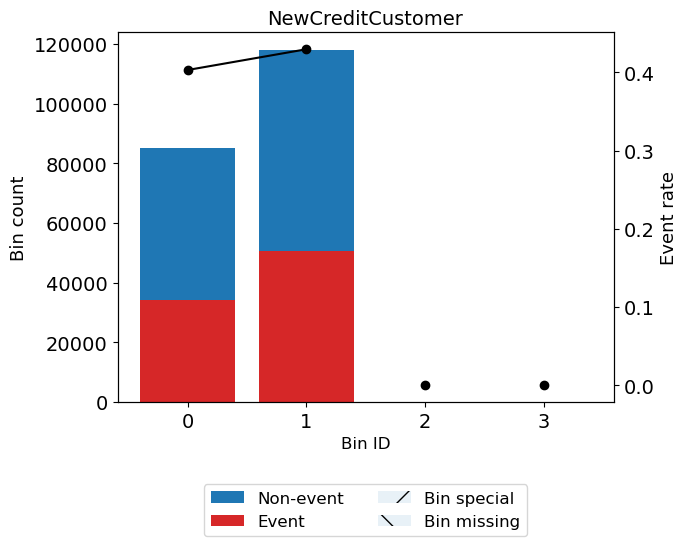

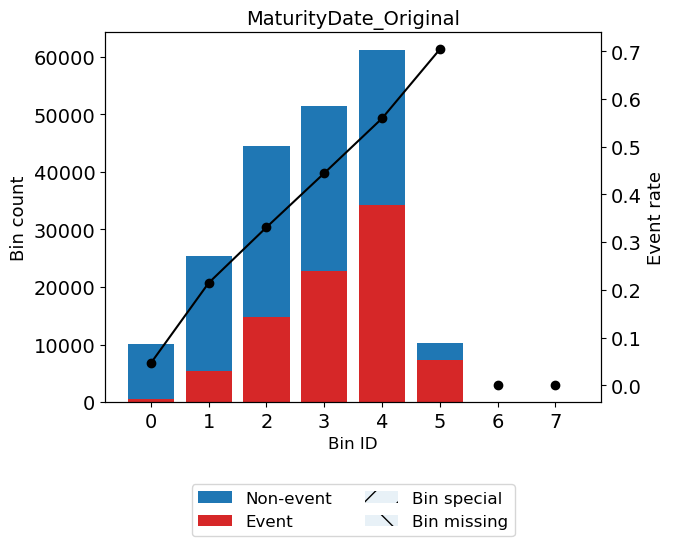

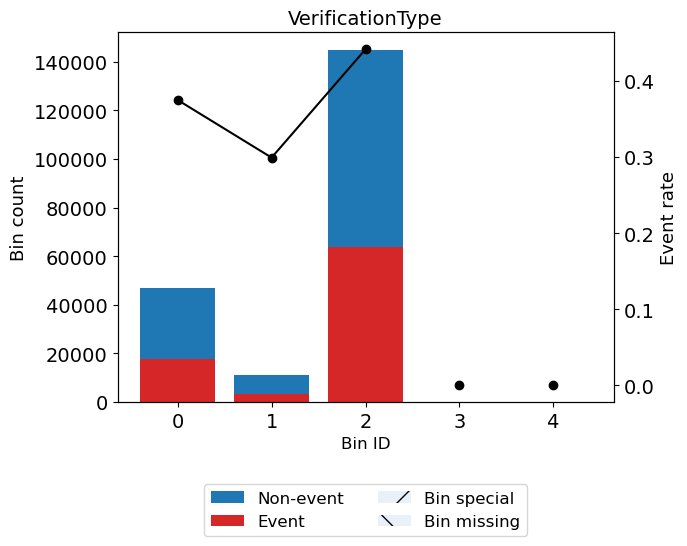

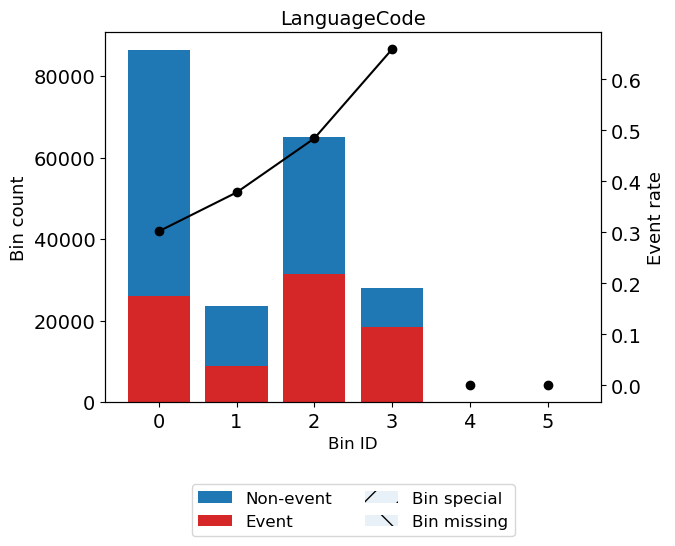

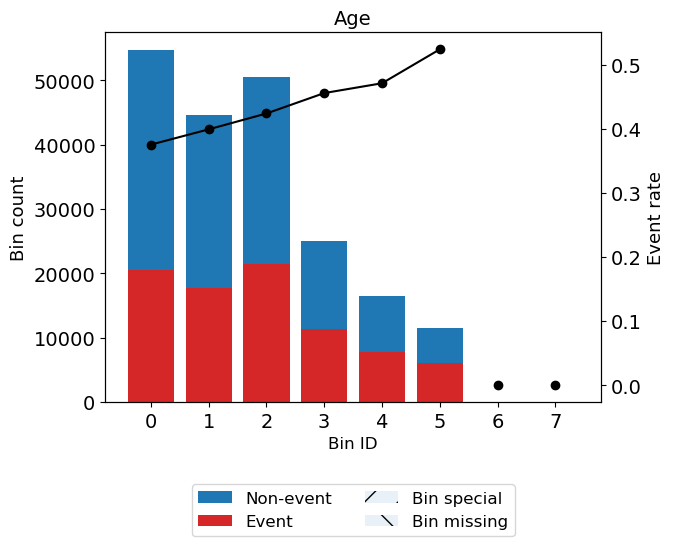

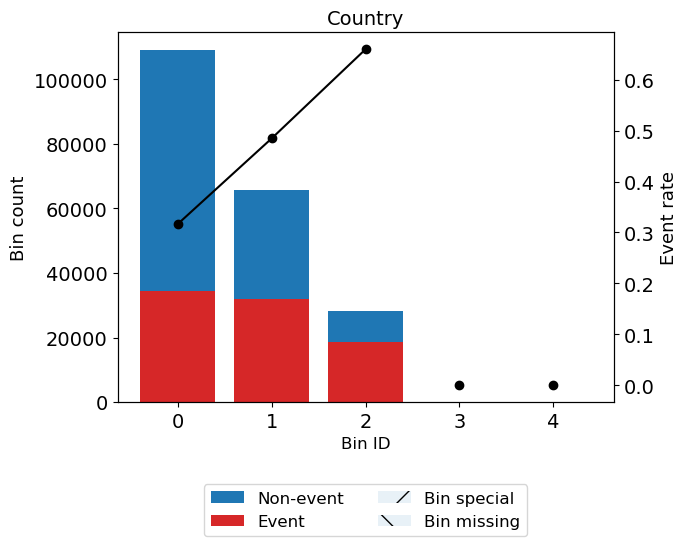

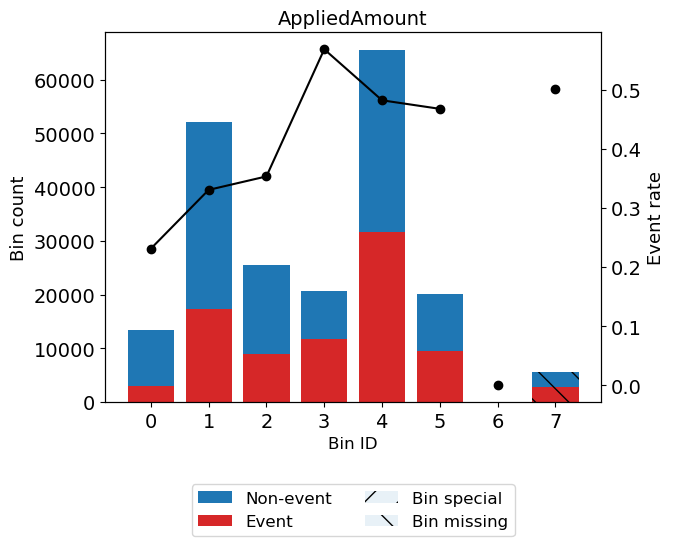

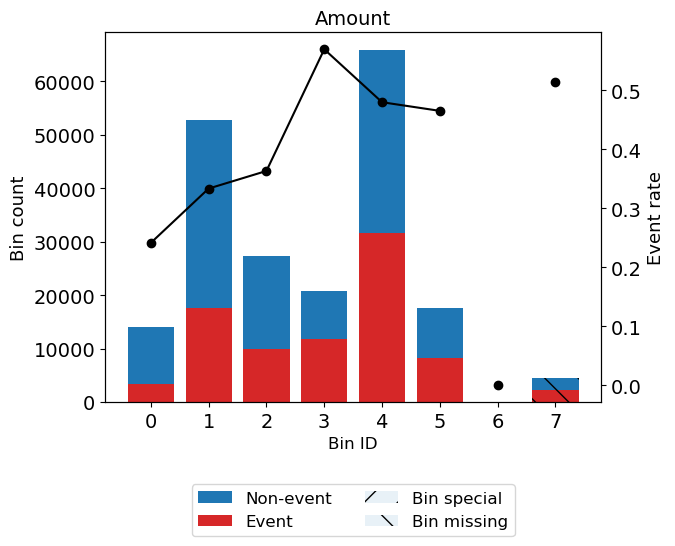

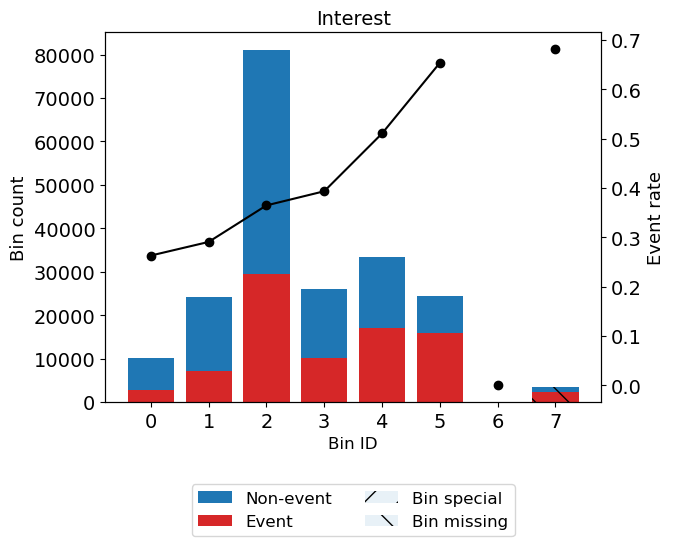

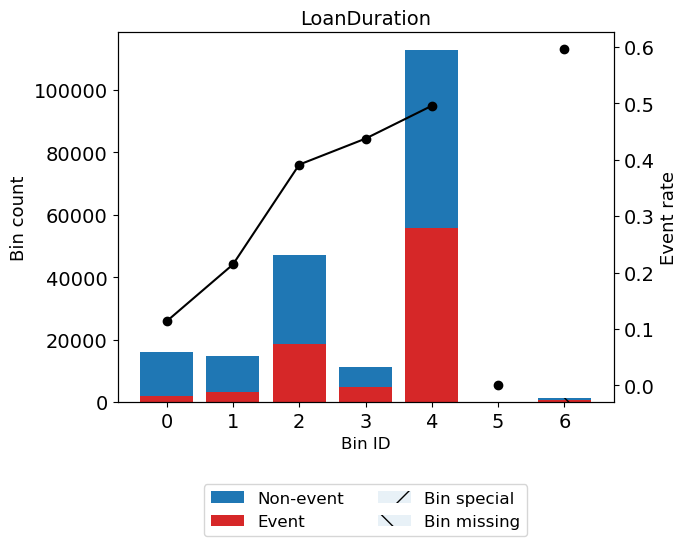

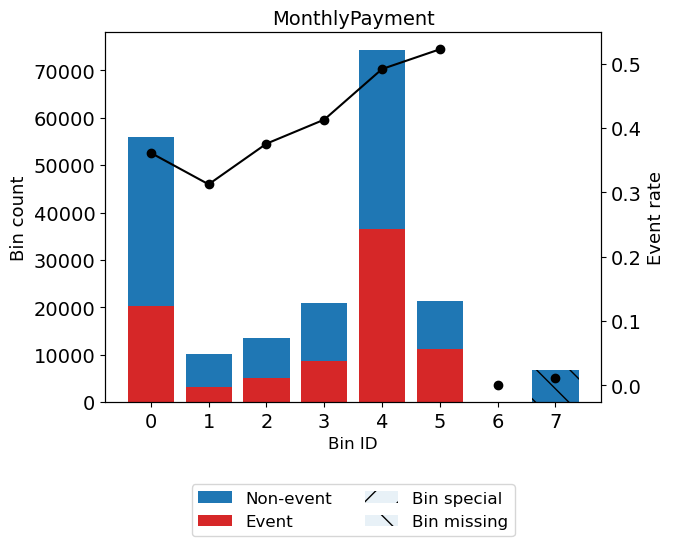

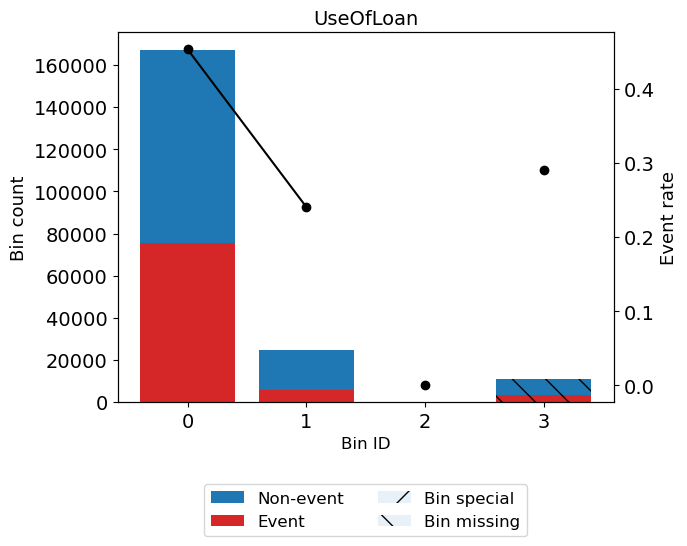

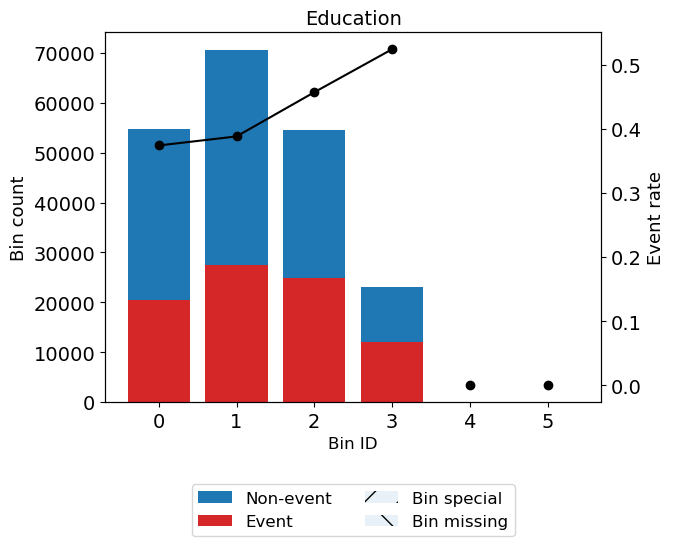

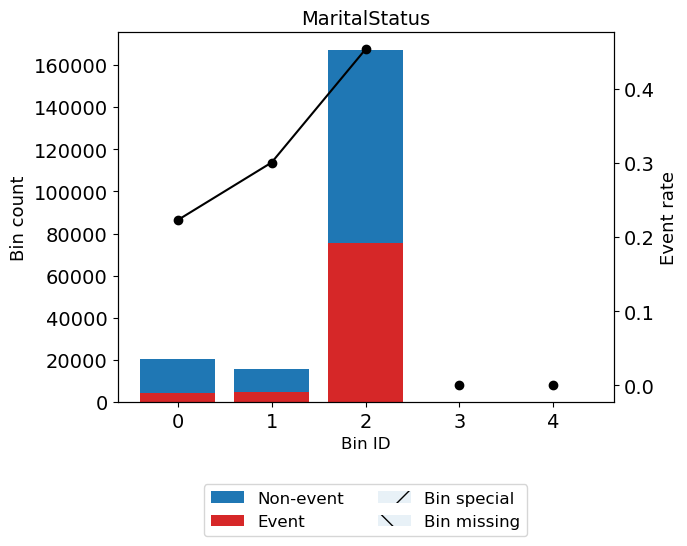

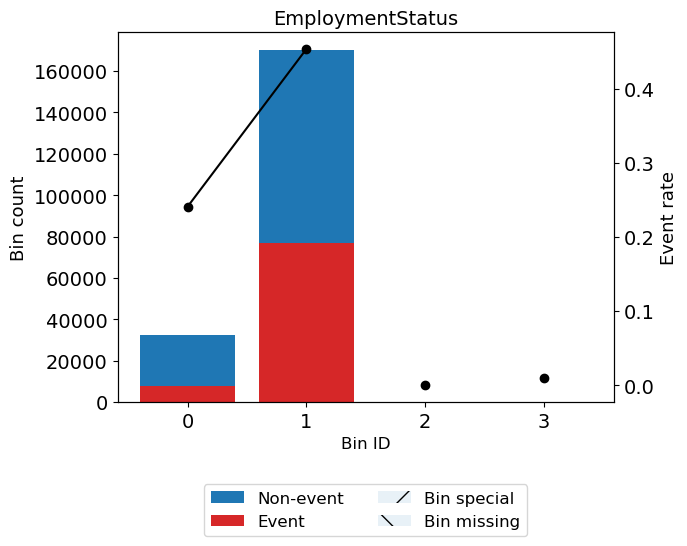

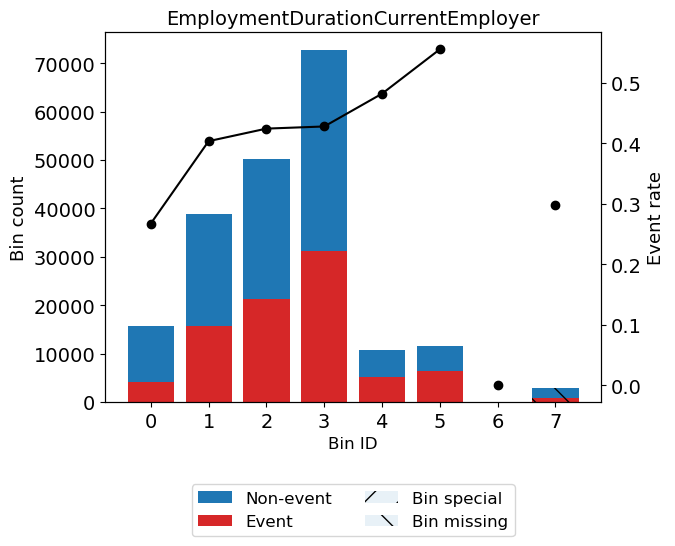

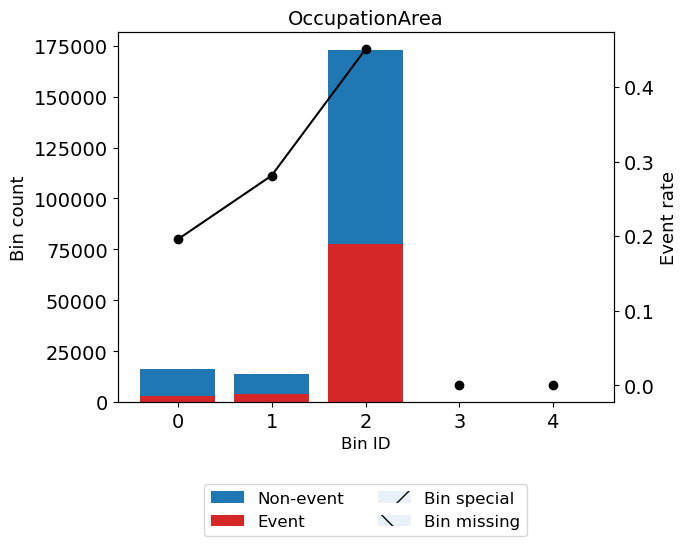

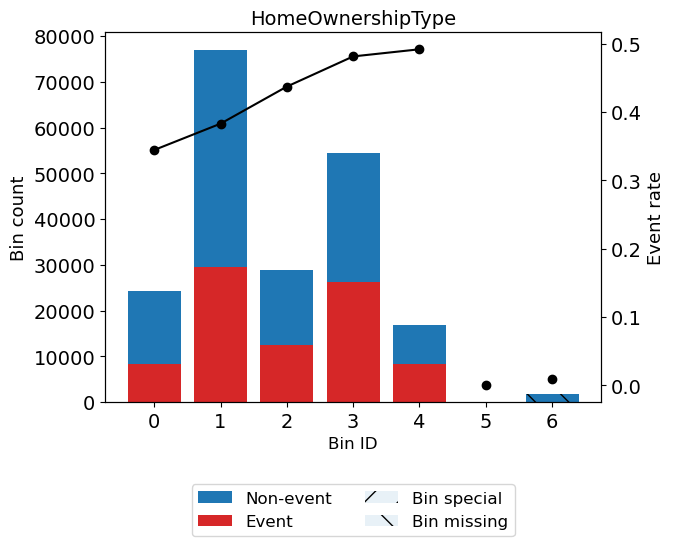

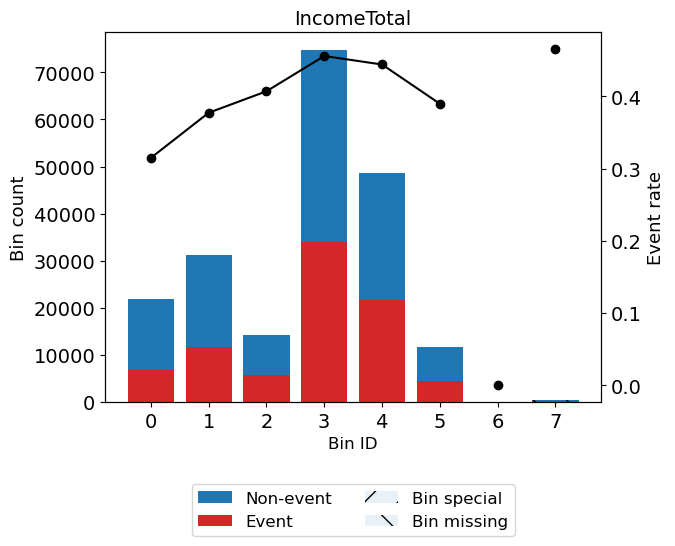

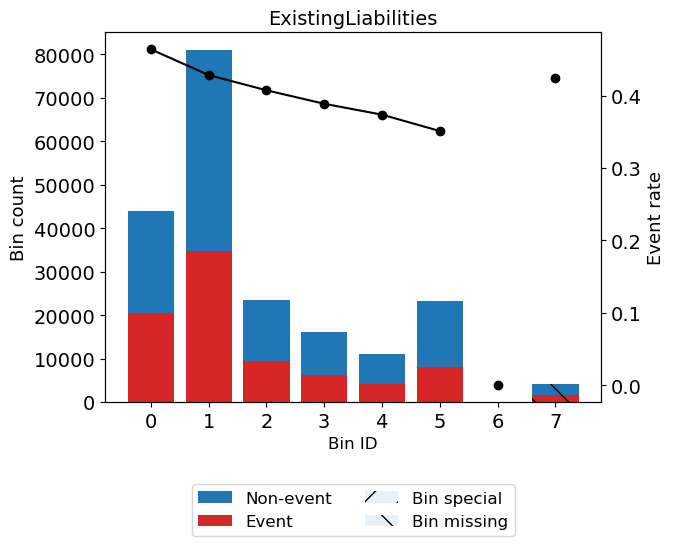

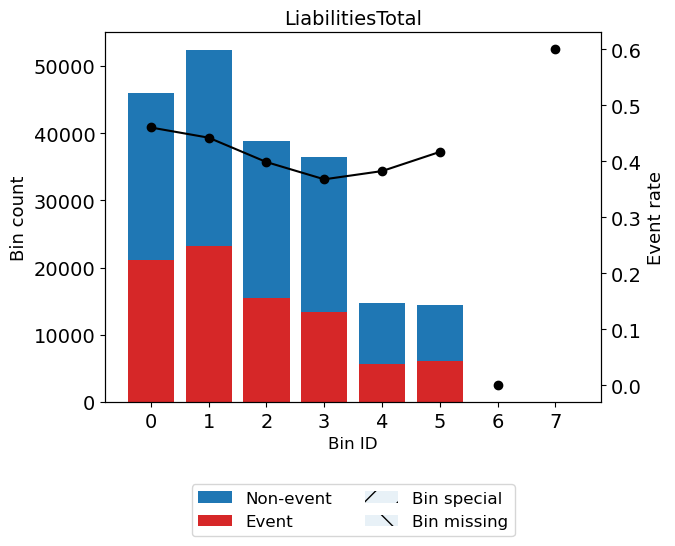

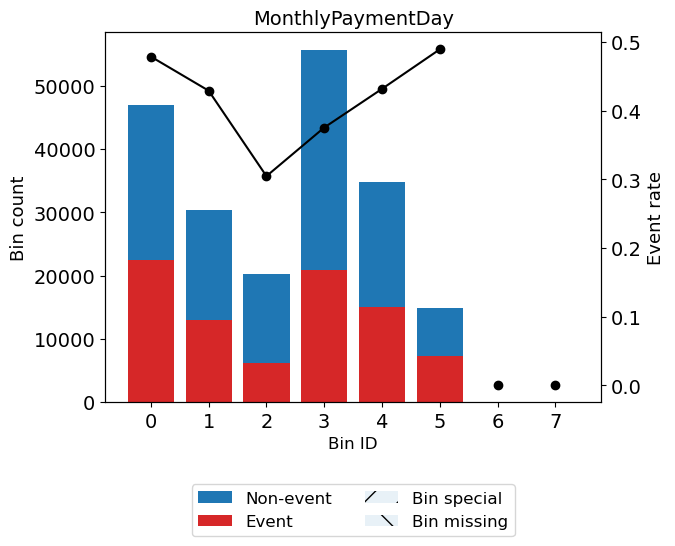

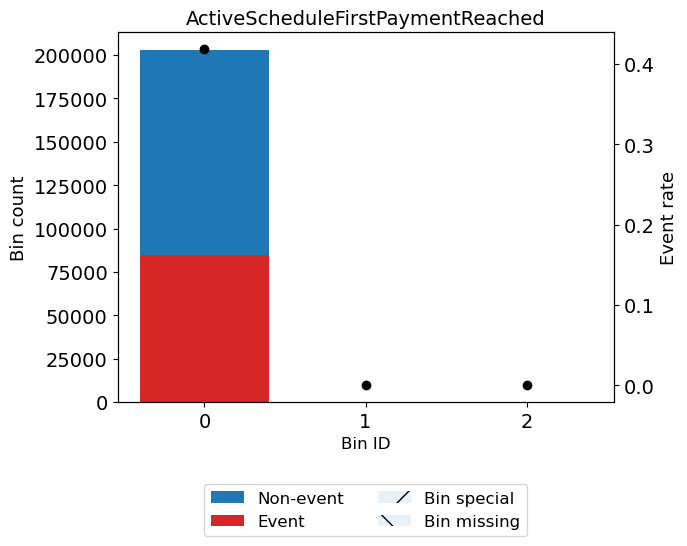

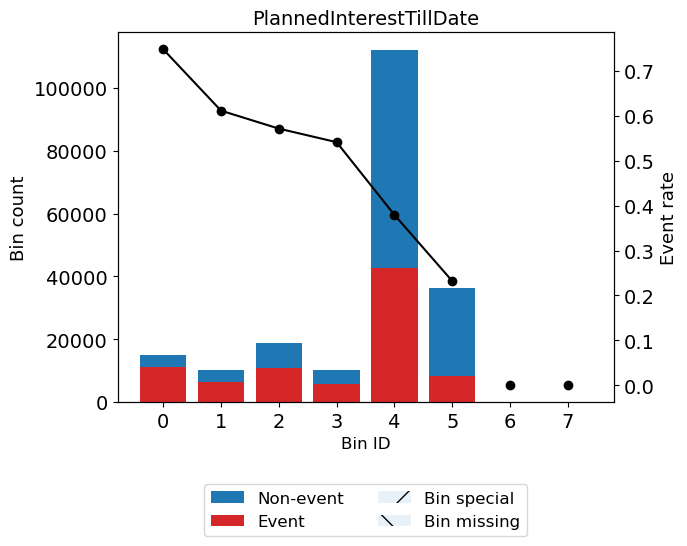

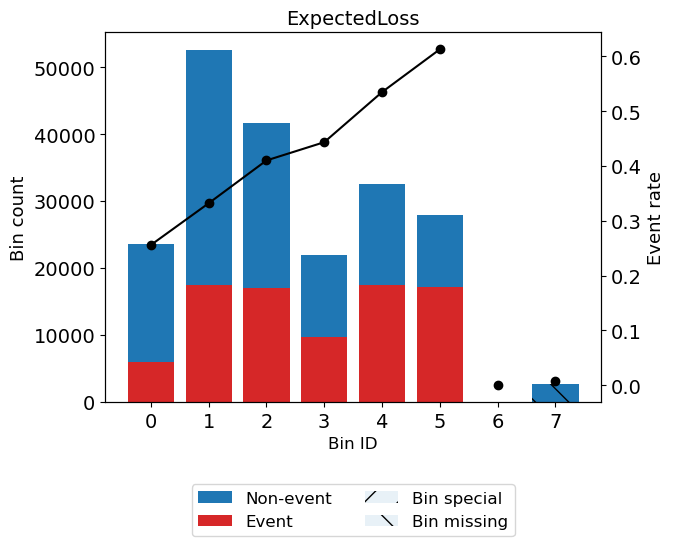

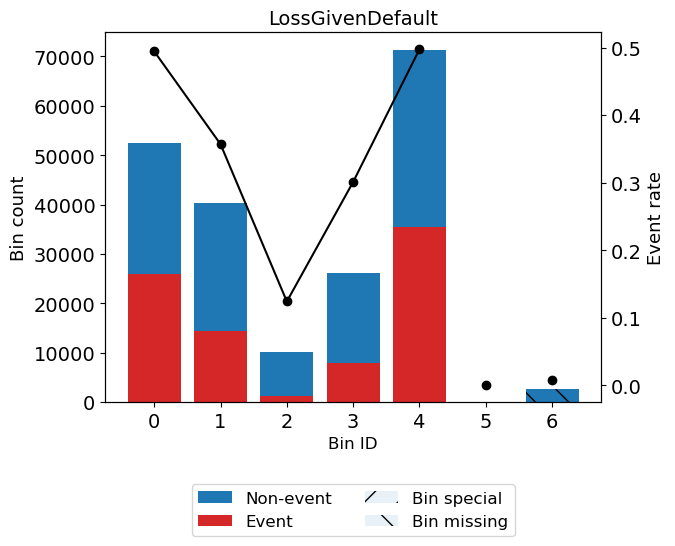

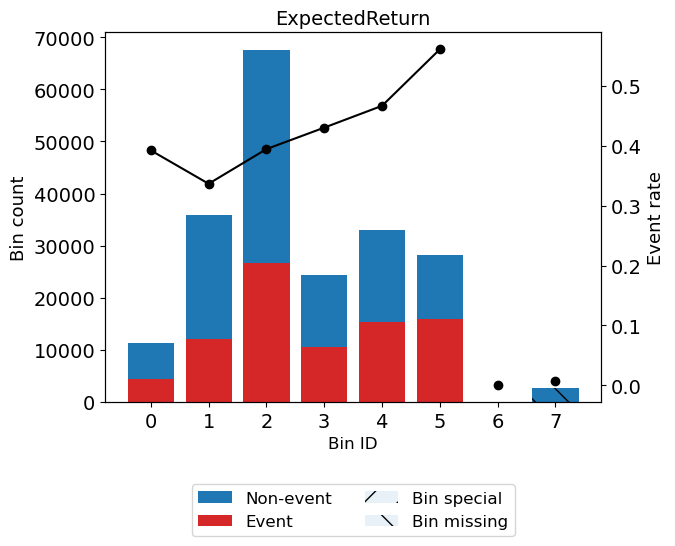

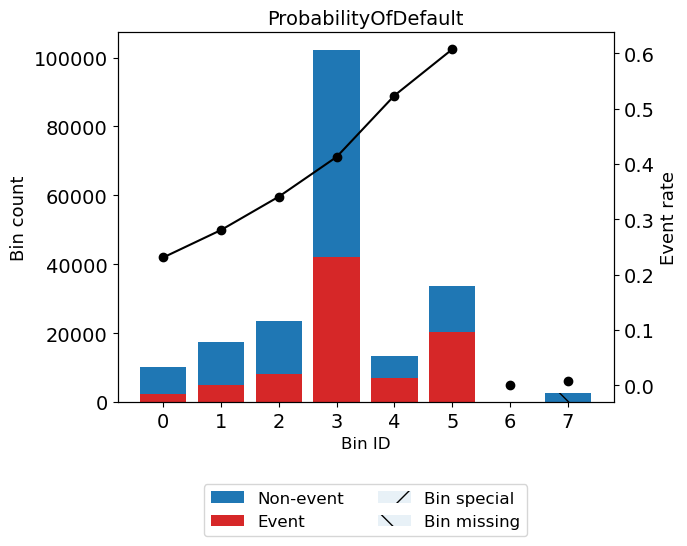

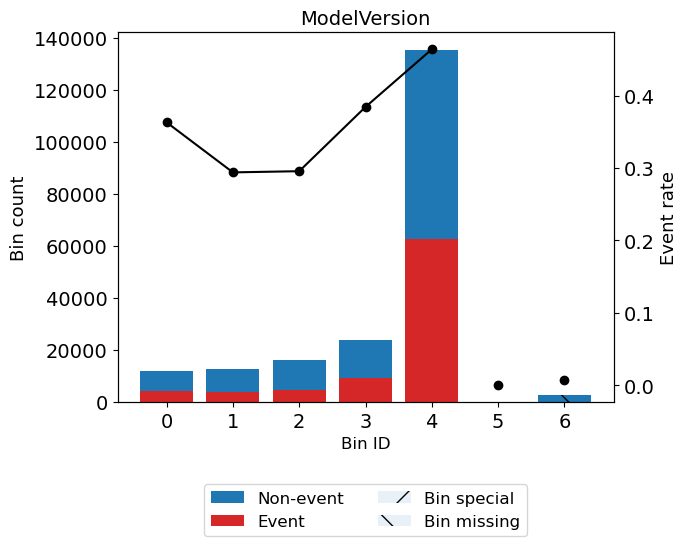

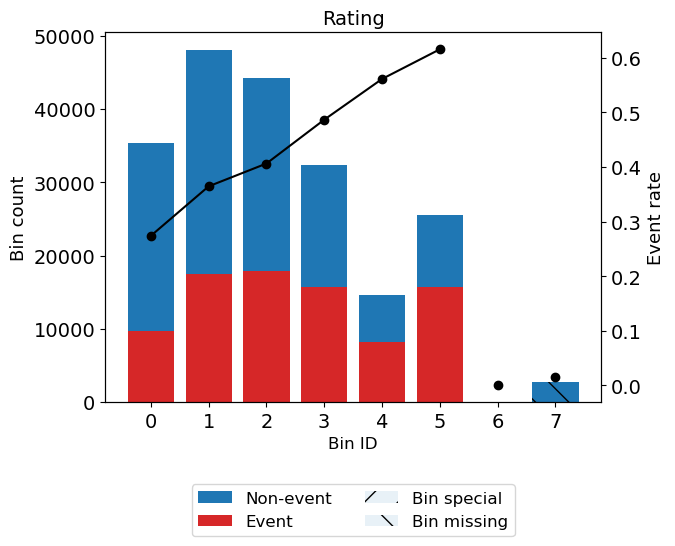

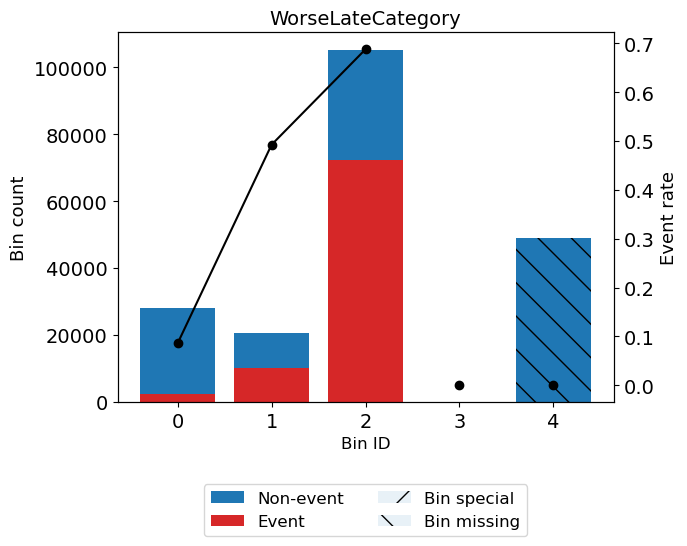

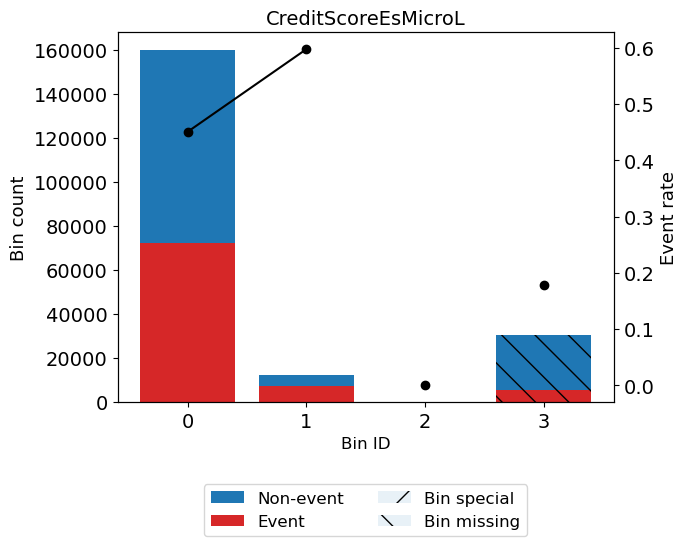

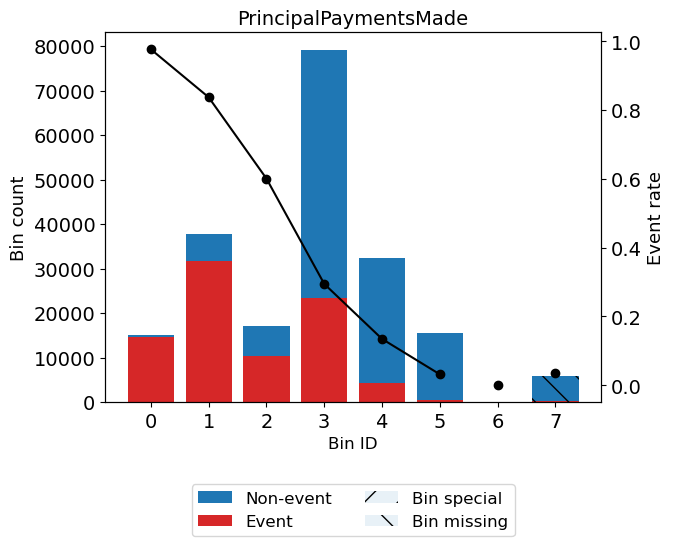

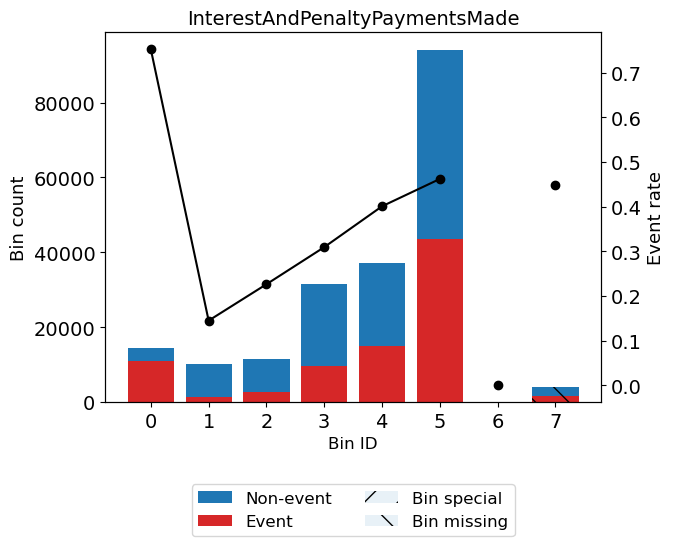

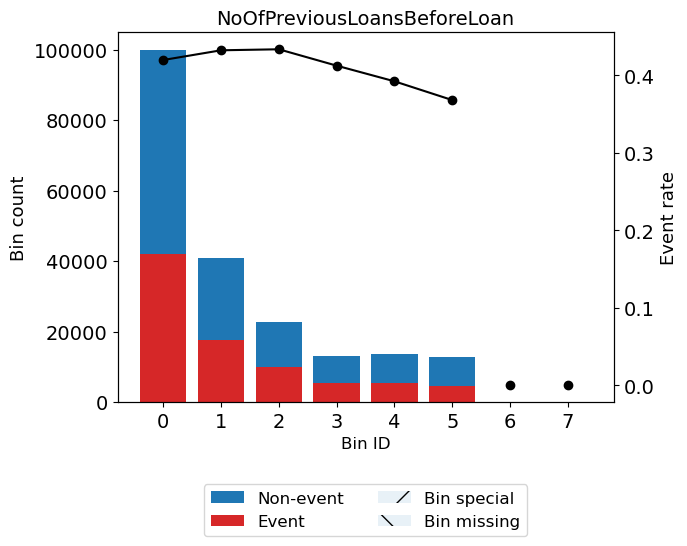

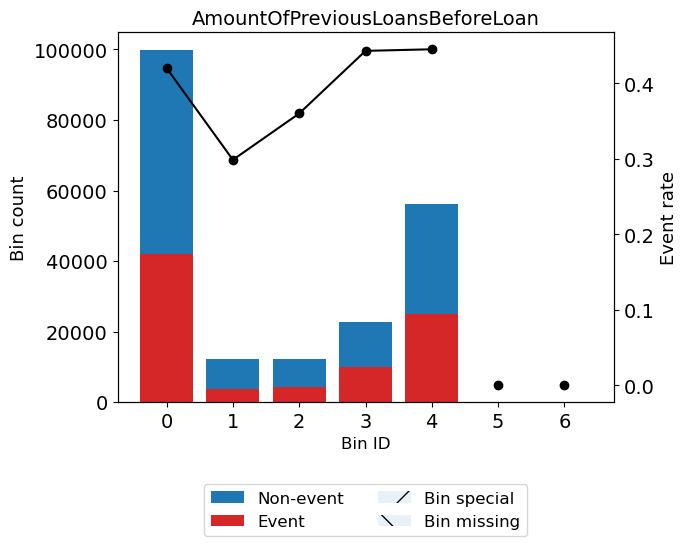

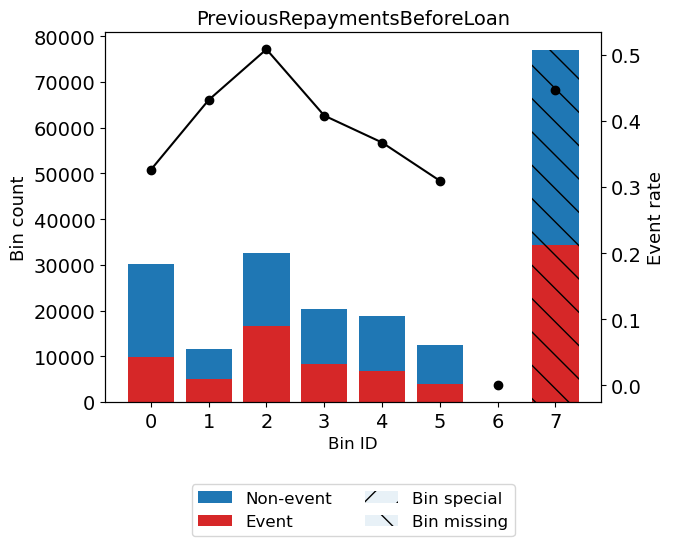

In [284]:
for variable in X:
    optb = binning_process.get_binned_variable(name=variable)
    optb.binning_table.plot(metric = "event_rate")

In [125]:
for variable in X:
    optb = binning_process.get_binned_variable(name=variable)
    print(optb.binning_table.build())

                 Bin   Count  Count (%)  Non-event  Event  Event rate  WoE  \
0       [2023-06-01]  162320        1.0      94443  67877    0.418168  0.0   
1            Special       0        0.0          0      0    0.000000  0.0   
2            Missing       0        0.0          0      0    0.000000  0.0   
Totals                162320        1.0      94443  67877    0.418168        

         IV   JS  
0       0.0  0.0  
1       0.0  0.0  
2       0.0  0.0  
Totals  0.0  0.0  
                                                      Bin   Count  Count (%)  \
0       [0000B9FA-5598-4130-9143-AB63012DC8D8, 9446072...  162320        1.0   
1                                                 Special       0        0.0   
2                                                 Missing       0        0.0   
Totals                                                     162320        1.0   

        Non-event  Event  Event rate  WoE   IV   JS  
0           94443  67877    0.418168  0.0  0.0  0.0  
1    

                   Bin   Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 6.50)   11654   0.071796       5885   5769    0.495023   
1         [6.50, 8.50)    9913   0.061071       5685   4228    0.426511   
2         [8.50, 9.50)   10054   0.061939       5803   4251    0.422817   
3        [9.50, 11.50)   27135   0.167170      15844  11291    0.416105   
4       [11.50, 14.50)   35967   0.221581      21146  14821    0.412072   
5       [14.50, 20.50)   54887   0.338141      32453  22434    0.408731   
6         [20.50, inf)   12710   0.078302       7627   5083    0.399921   
7              Special       0   0.000000          0      0    0.000000   
8              Missing       0   0.000000          0      0    0.000000   
Totals                  162320   1.000000      94443  67877    0.418168   

             WoE        IV        JS  
0      -0.310391  0.007039  0.000876  
1      -0.034197  0.000072  0.000009  
2      -0.019078  0.000023  0.000003  
3       0.008486  

                 Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.34)   41967   0.258545      21174  20793    0.495461   
1       [0.34, 0.58)   32156   0.198103      20730  11426    0.355330   
2       [0.58, 0.64)   18461   0.113732      12711   5750    0.311467   
3       [0.64, 0.65)   10579   0.065174       9045   1534    0.145004   
4        [0.65, inf)   57024   0.351306      28666  28358    0.497299   
5            Special       0   0.000000          0      0    0.000000   
6            Missing    2133   0.013141       2117     16    0.007501   
Totals                162320   1.000000      94443  67877    0.418168   

             WoE        IV        JS  
0      -0.312142  0.025638  0.003192  
1       0.265391  0.013578  0.001692  
2       0.462969  0.023092  0.002861  
3       1.444034  0.105663  0.012168  
4      -0.319497  0.036505  0.004544  
5            0.0  0.000000  0.000000  
6       4.554867  0.101027  0.007195  
Totals            0.305503  0.

In [285]:
optb = binning_process.get_binned_variable(name='PrincipalPaymentsMade')
optb.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0            (-inf, 31.92)   14968   0.073773        353  14615    0.976416   
1          [31.92, 309.96)   37805   0.186329       6161  31644    0.837032   
2         [309.96, 499.74)   17109   0.084325       6831  10278    0.600736   
3        [499.74, 1998.53)   79099   0.389854      55800  23299    0.294555   
4       [1998.53, 4143.20)   32382   0.159601      28022   4360    0.134643   
5           [4143.20, inf)   15618   0.076976      15122    496    0.031758   
6                  Special       0   0.000000          0      0    0.000000   
7                  Missing    5913   0.029143       5703    210    0.035515   
Totals                      202894   1.000000     117992  84902    0.418455   

             WoE        IV        JS  
0      -4.052455  0.685464  0.053125  
1      -1.965429  0.629913  0.068099  
2      -0.737654  0.046593  0.005696  
3       0.544244  0.108028  0.013339  
4       1.531399  0.285050  0.032513  
5       3.088211  0.377747  0.034435  
6            0.0  0.000000  0.000000  
7       2.972521  0.136321  0.012664  
Totals            2.269117  0.219871

=> Remove 3 variables,namely: 
-marital_status, salary_account_flag: more than 80% obs fall into 1 or 2 attributes
-collateral_type: Good/Bad line not showing monotonic trend clearly (Event_rates are quite simmilar through bins)

In [29]:
list1 = ['marital_status', 'salary_account_flag', 'collateral_type' ]

2.2. Accuracy ratio(AR) and IV (information value)

In [48]:
#Plot WOE trend for each variable

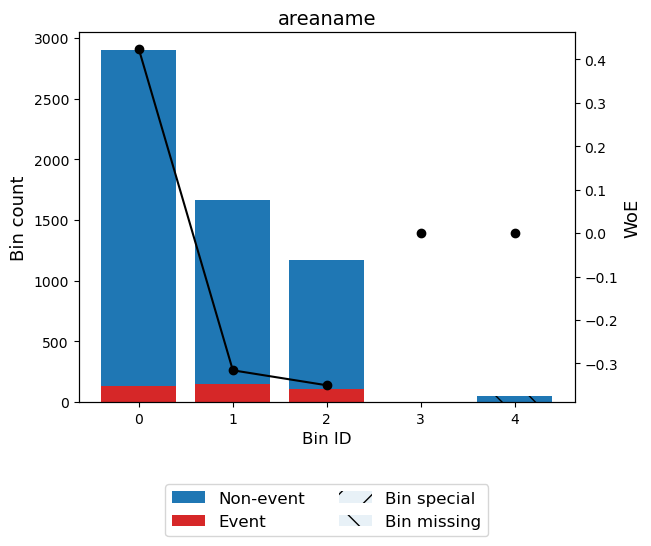

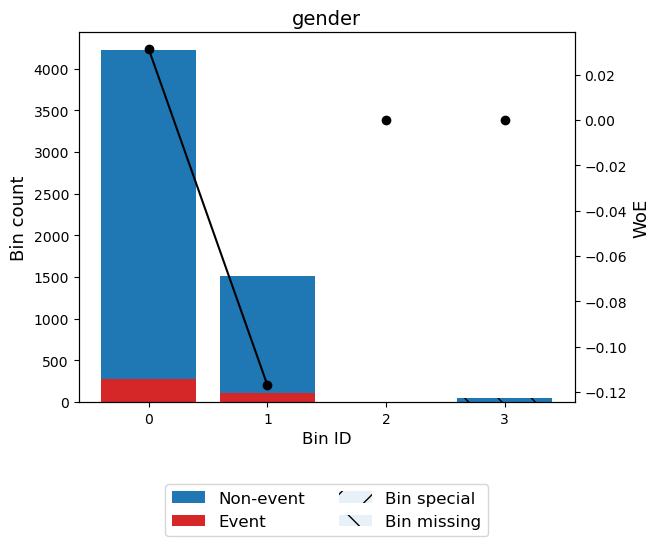

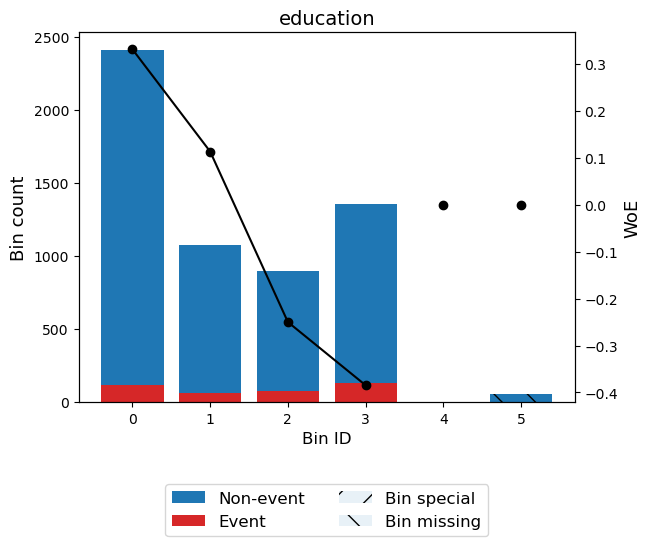

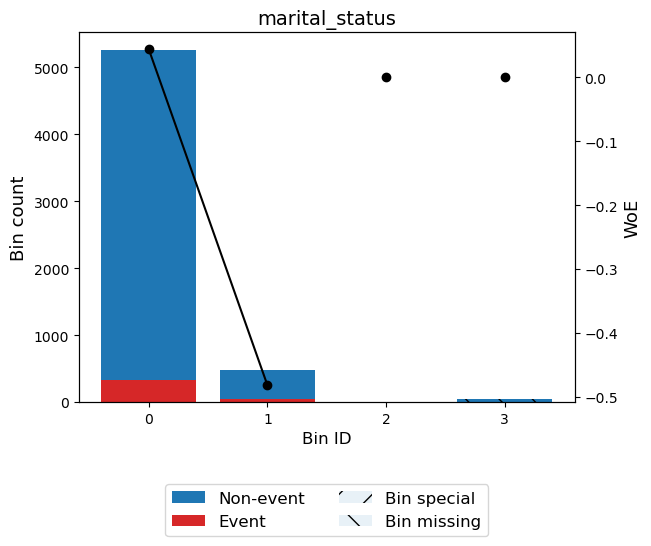

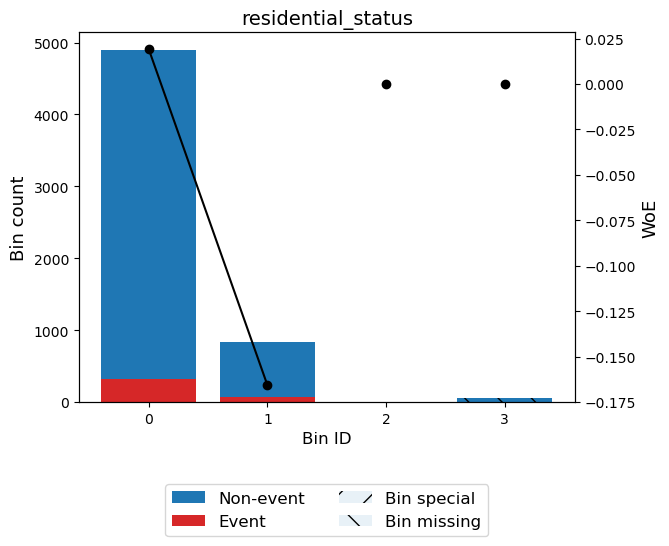

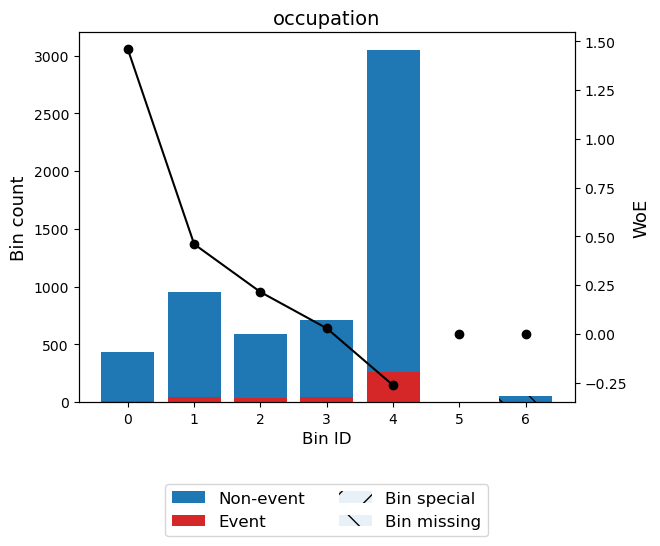

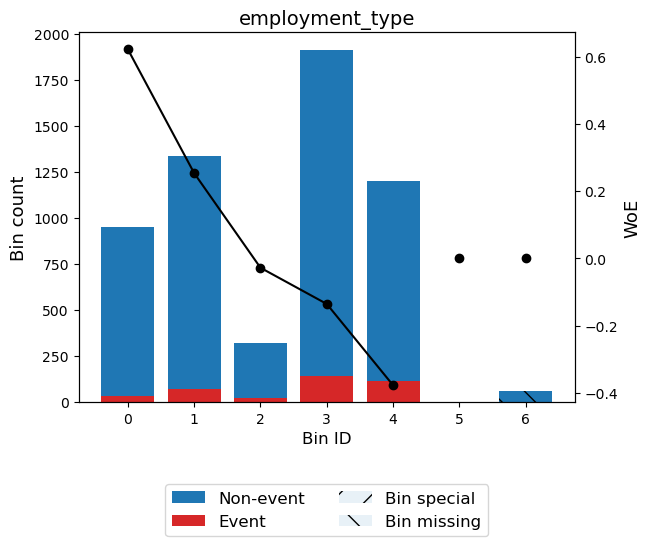

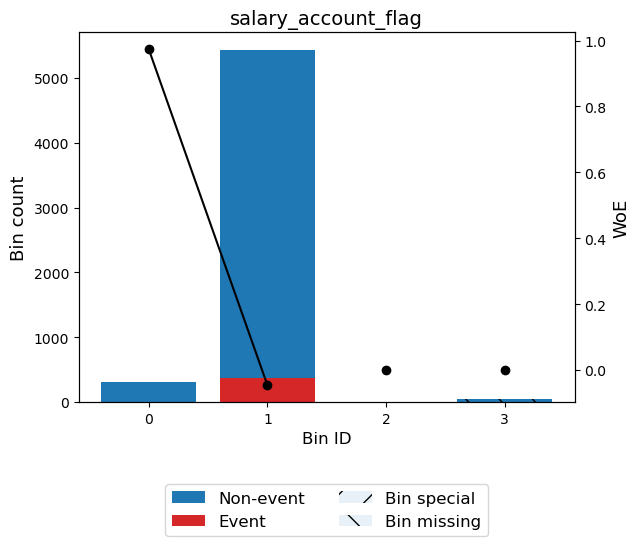

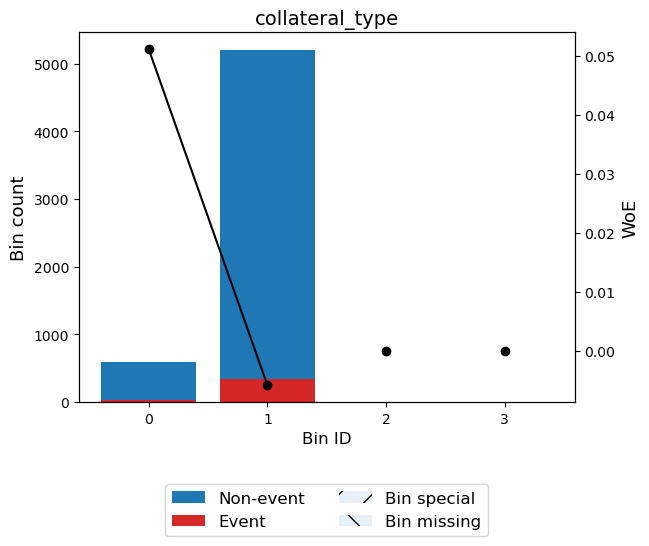

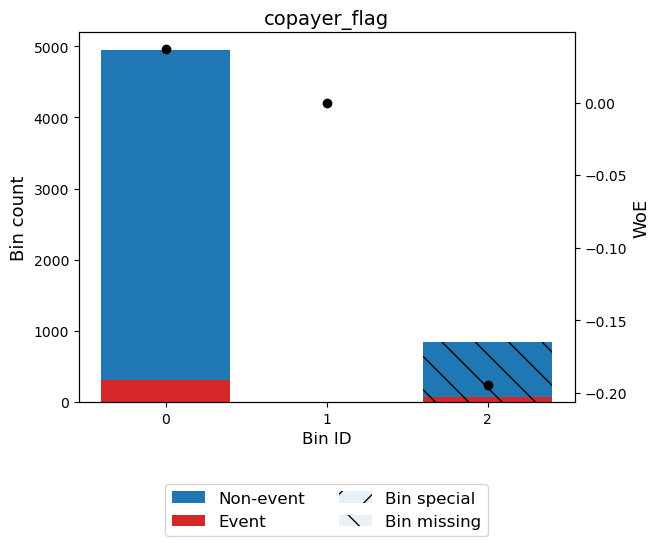

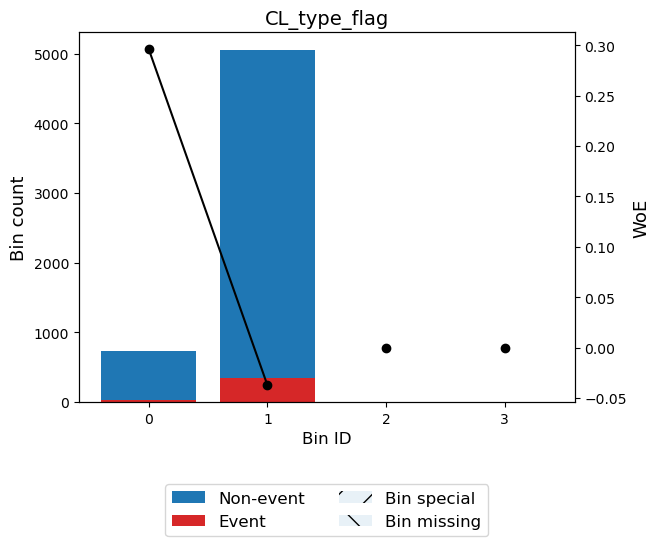

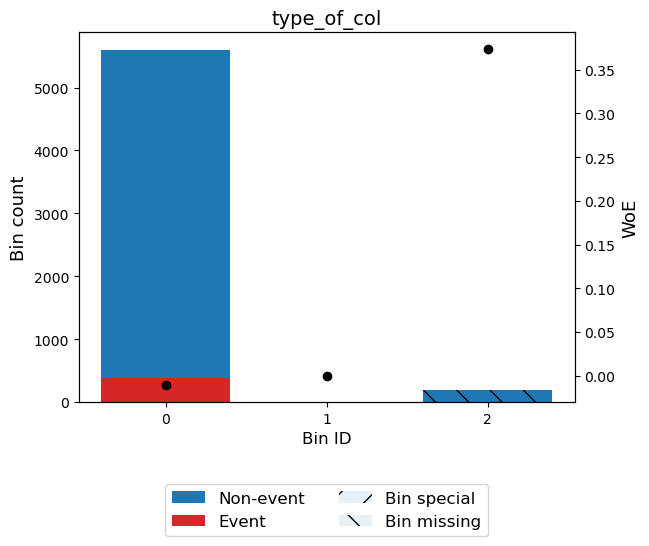

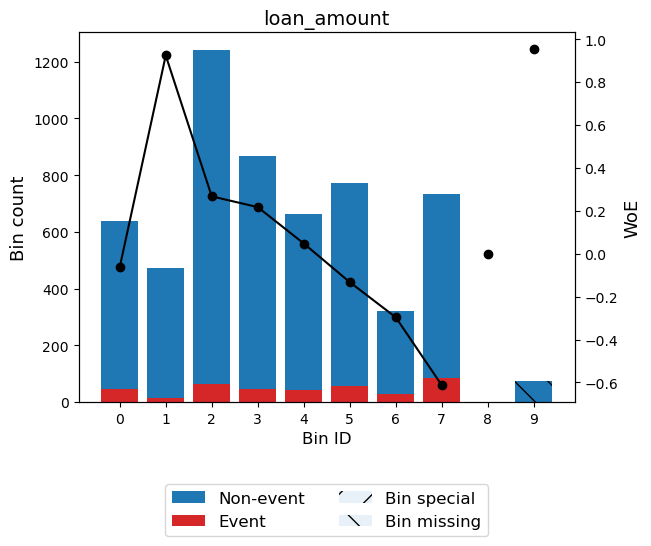

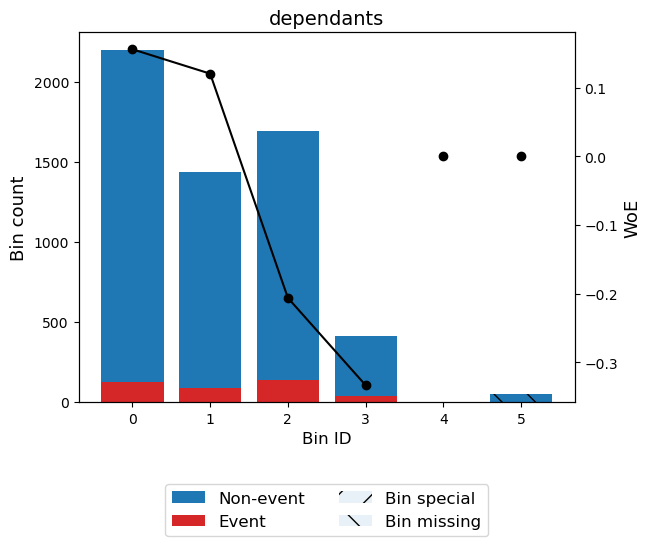

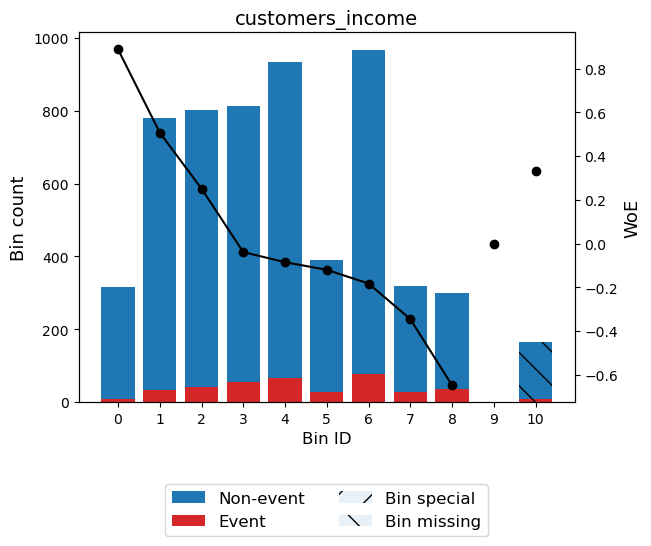

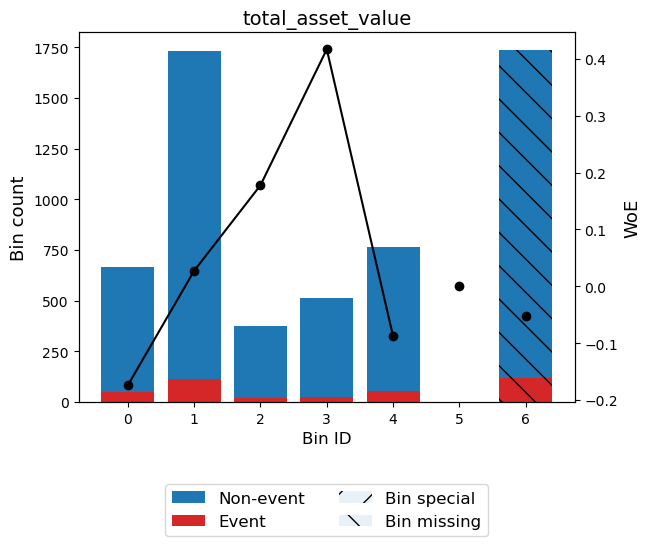

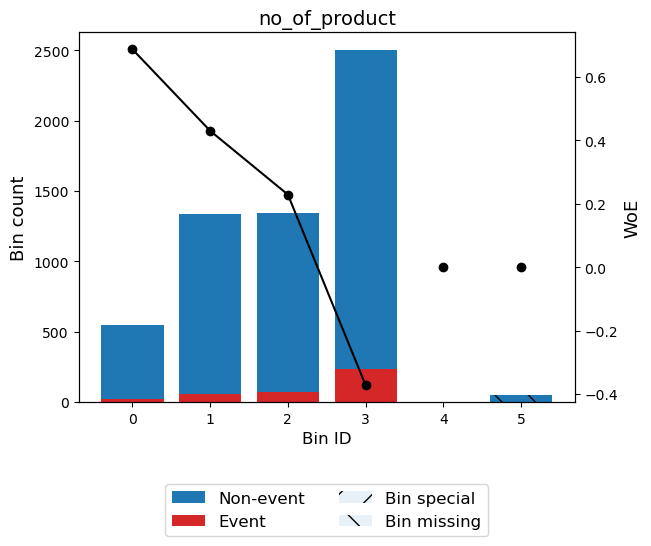

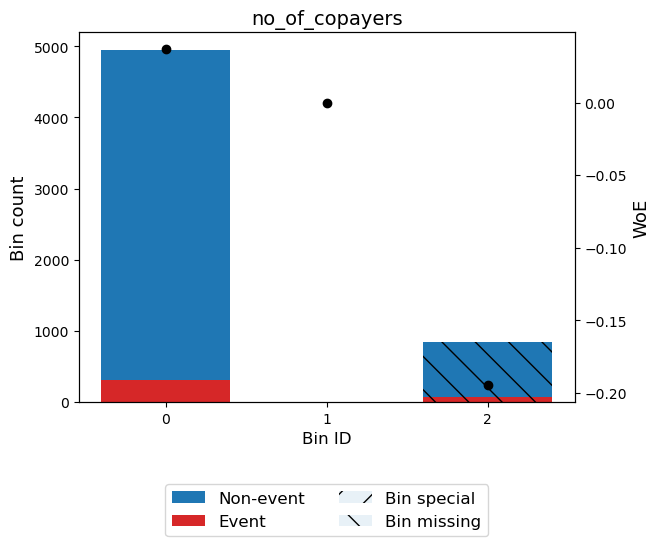

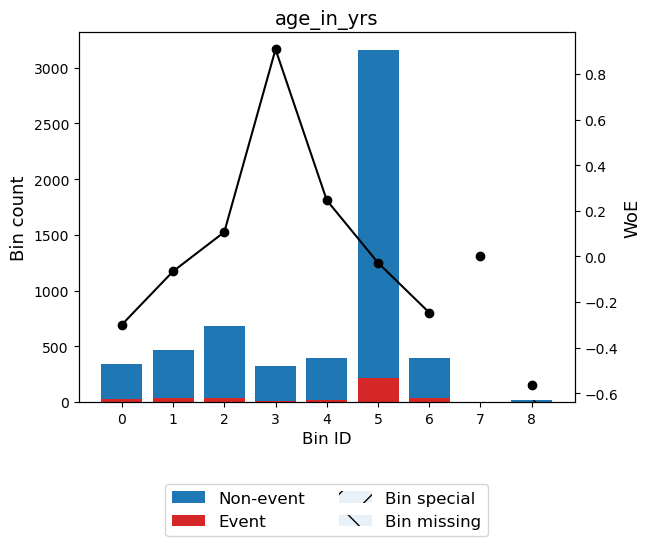

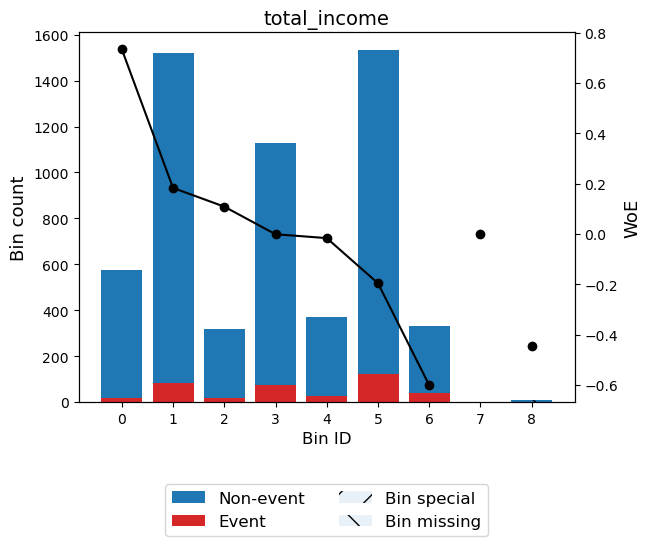

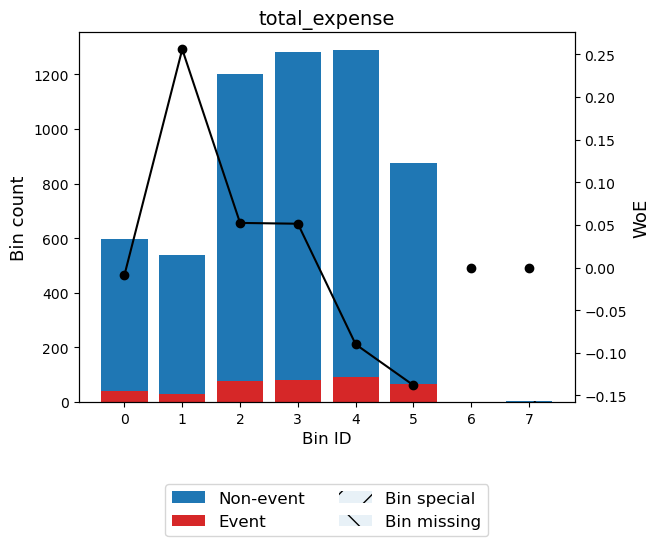

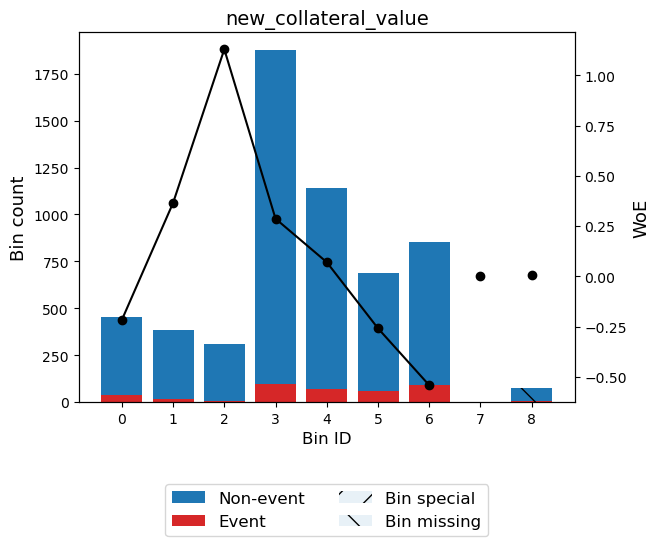

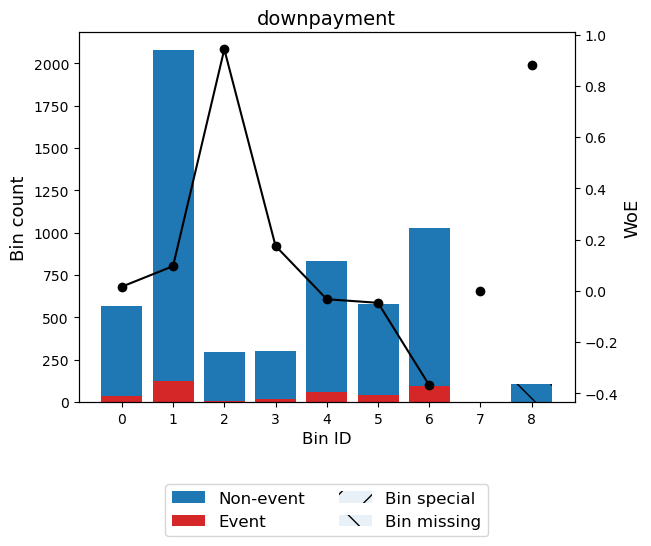

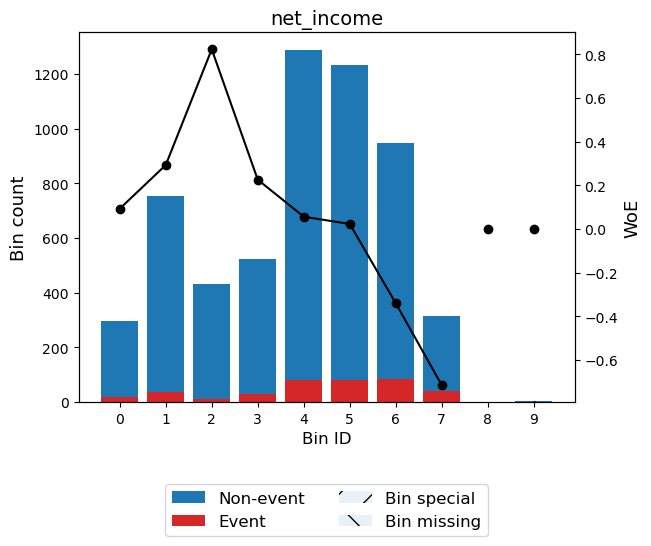

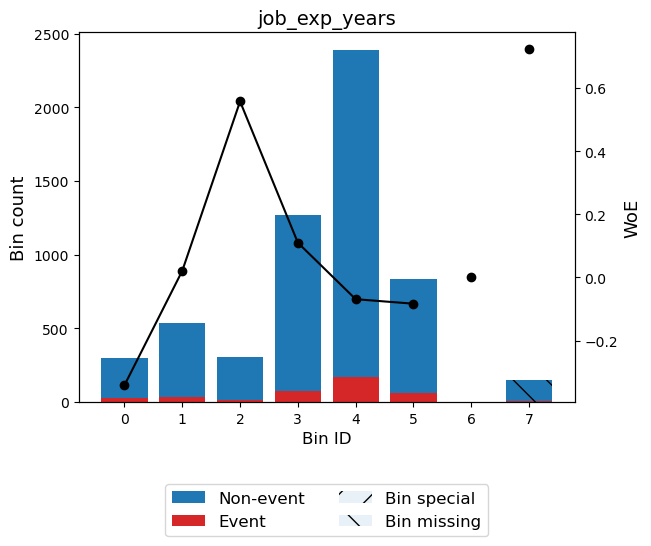

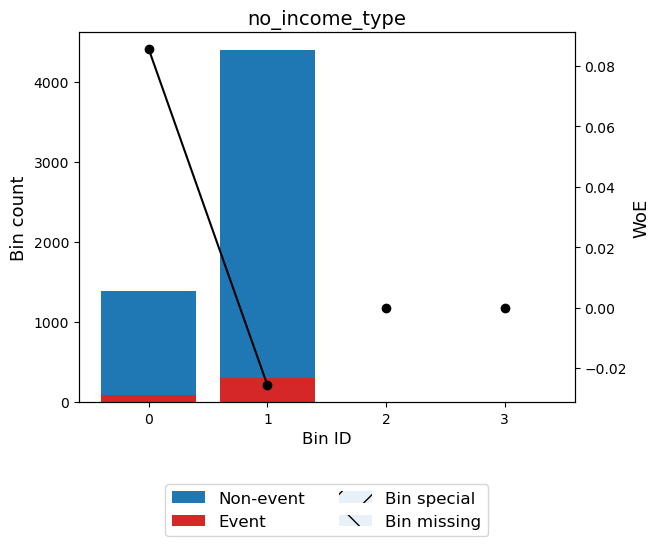

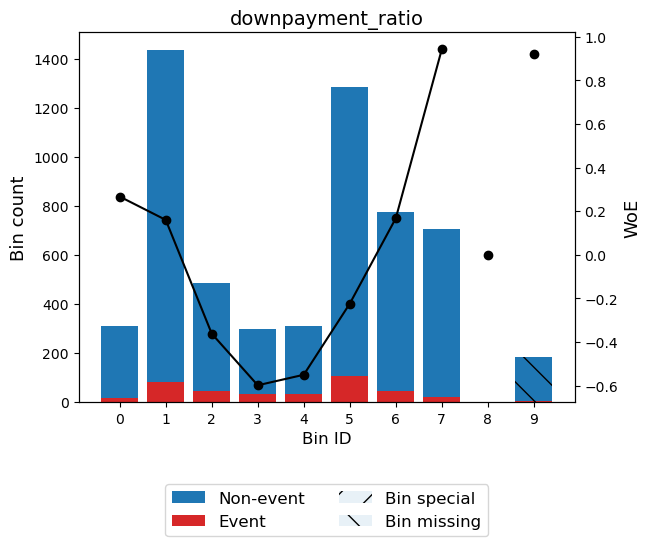

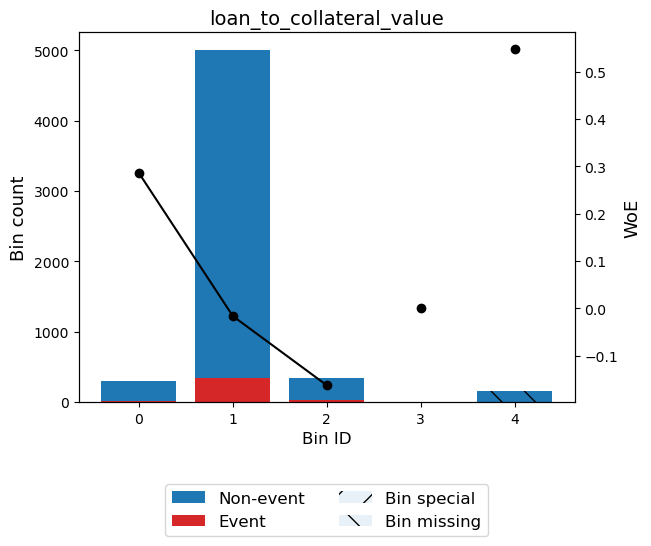

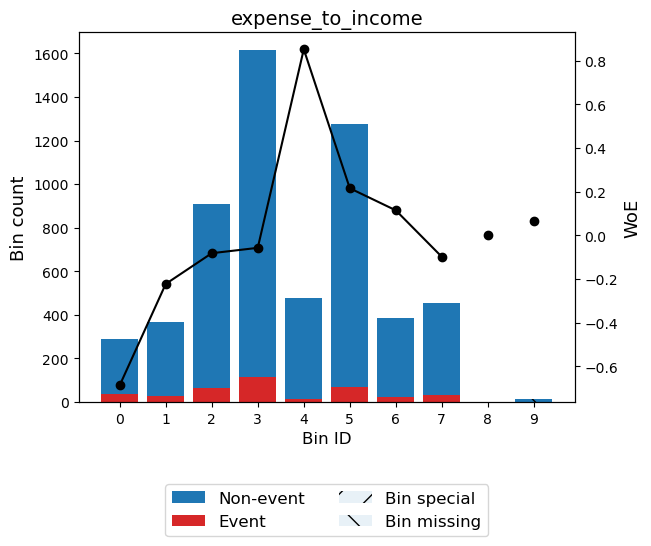

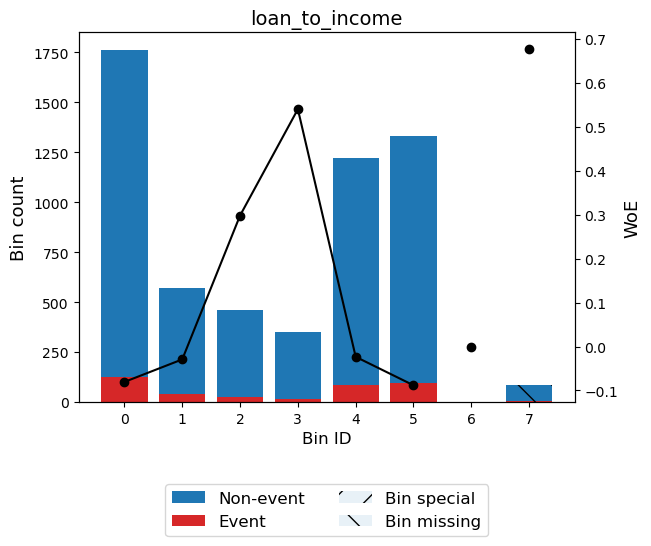

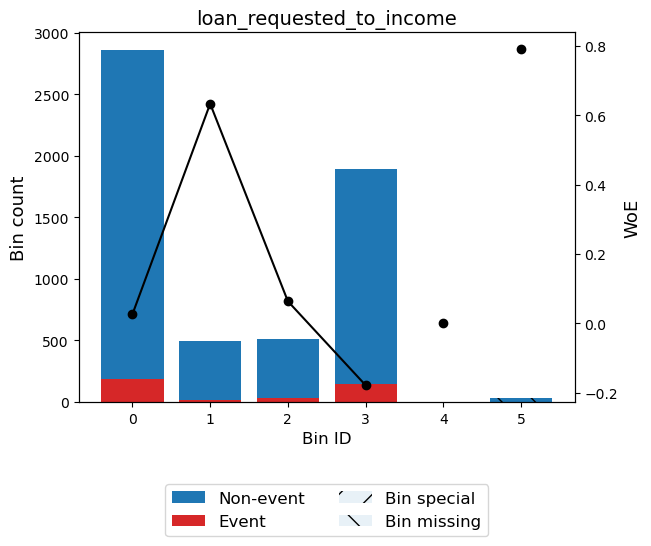

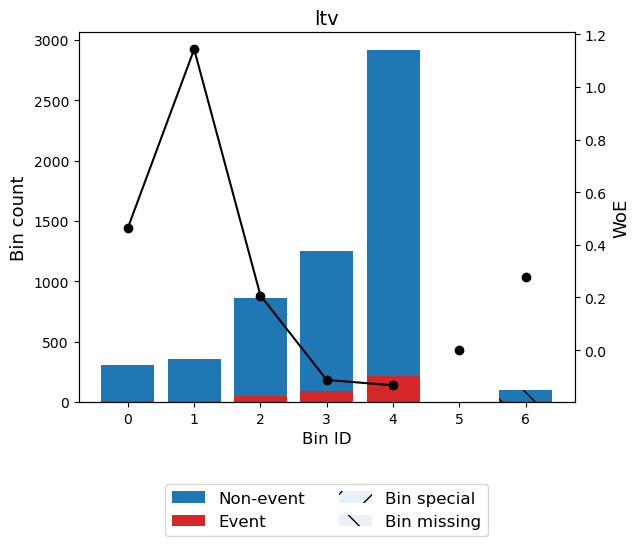

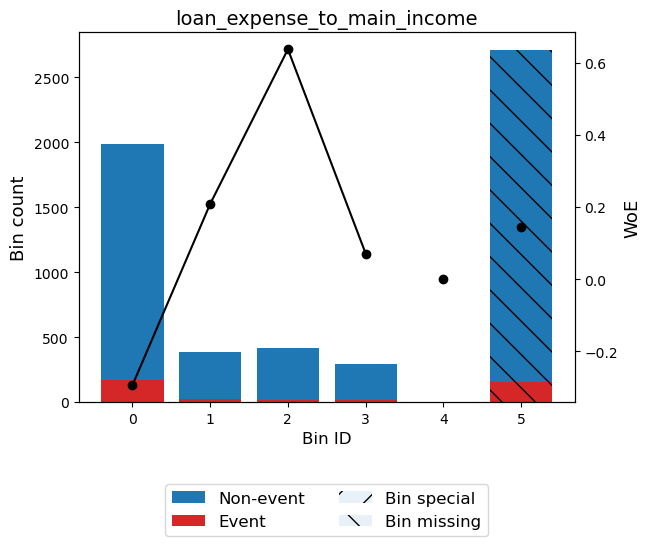

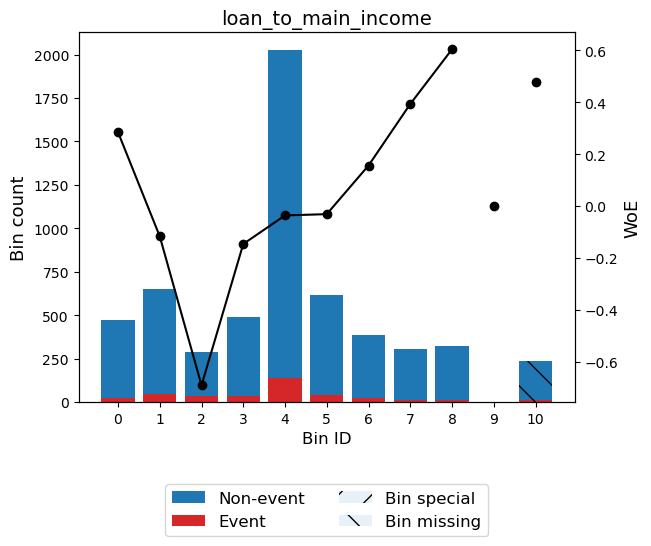

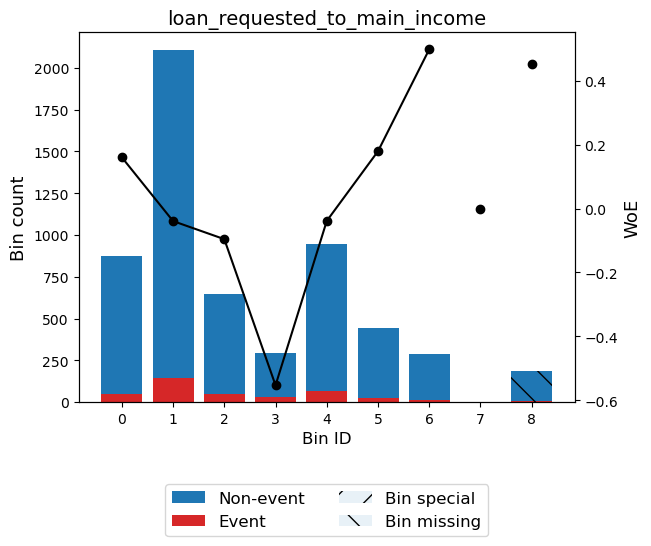

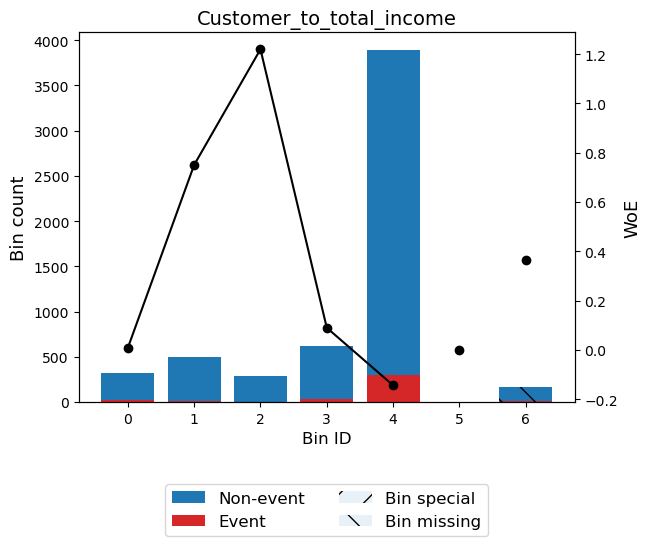

In [36]:
for variable in np.delete(variable_names,0):
    optb = binning_process.get_binned_variable(name=variable)
    optb.binning_table.plot(metric = "woe")

In [295]:
df5 = binning_process.summary()

In [296]:
df5

name        dtype   status  selected n_bins  \
0                   NewCreditCustomer  categorical  OPTIMAL      True      2   
1               MaturityDate_Original  categorical  OPTIMAL      True      6   
2                    VerificationType    numerical  OPTIMAL      True      3   
3                        LanguageCode  categorical  OPTIMAL      True      4   
4                                 Age    numerical  OPTIMAL      True      6   
5                             Country  categorical  OPTIMAL      True      3   
6                       AppliedAmount    numerical  OPTIMAL      True      6   
7                              Amount    numerical  OPTIMAL      True      6   
8                            Interest    numerical  OPTIMAL      True      6   
9                        LoanDuration    numerical  OPTIMAL      True      5   
10                     MonthlyPayment    numerical  OPTIMAL      True      6   
11                          UseOfLoan    numerical  OPTIMAL      True      2   
12                          Education  categorical  OPTIMAL      True      4   
13                      MaritalStatus  categorical  OPTIMAL      True      3   
14                   EmploymentStatus  categorical  OPTIMAL      True      2   
15  EmploymentDurationCurrentEmployer  categorical  OPTIMAL      True      6   
16                     OccupationArea  categorical  OPTIMAL      True      3   
17                  HomeOwnershipType  categorical  OPTIMAL      True      5   
18                        IncomeTotal    numerical  OPTIMAL      True      6   
19                ExistingLiabilities    numerical  OPTIMAL      True      6   
20                   LiabilitiesTotal    numerical  OPTIMAL      True      6   
21                  MonthlyPaymentDay    numerical  OPTIMAL      True      6   
22  ActiveScheduleFirstPaymentReached  categorical  OPTIMAL      True      1   
23            PlannedInterestTillDate    numerical  OPTIMAL      True      6   
24                       ExpectedLoss    numerical  OPTIMAL      True      6   
25                   LossGivenDefault    numerical  OPTIMAL      True      5   
26                     ExpectedReturn    numerical  OPTIMAL      True      6   
27               ProbabilityOfDefault    numerical  OPTIMAL      True      6   
28                       ModelVersion    numerical  OPTIMAL      True      5   
29                             Rating  categorical  OPTIMAL      True      6   
30                  WorseLateCategory  categorical  OPTIMAL      True      3   
31                CreditScoreEsMicroL  categorical  OPTIMAL      True      2   
32              PrincipalPaymentsMade    numerical  OPTIMAL      True      6   
33     InterestAndPenaltyPaymentsMade    numerical  OPTIMAL      True      6   
34        NoOfPreviousLoansBeforeLoan    numerical  OPTIMAL      True      6   
35    AmountOfPreviousLoansBeforeLoan    numerical  OPTIMAL      True      5   
36       PreviousRepaymentsBeforeLoan    numerical  OPTIMAL      True      6   

          iv        js      gini quality_score  
0   0.002894  0.000362  0.026519      0.007826  
1   0.510628  0.056914  0.349716      0.820831  
2   0.027863  0.003462  0.072365      0.062825  
3   0.264462  0.032258  0.270027      0.723024  
4    0.02716  0.003383  0.089419      0.101939  
5   0.258926  0.031594  0.257595       0.63898  
6   0.155373  0.019142  0.210706      0.539926  
7    0.14663  0.018084  0.206685      0.511904  
8   0.234492  0.028542  0.250347      0.716789  
9   0.289892  0.033628   0.22921      0.670824  
10  0.306005  0.027229  0.198209       0.82141  
11  0.105859  0.012957  0.119154      0.172592  
12  0.042312  0.005266  0.106471      0.151697  
13  0.109666  0.013368   0.12027       0.16832  
14  0.120011  0.014314  0.119126      0.172729  
15  0.059029  0.007268  0.104105      0.165756  
16   0.11727  0.014153  0.114069      0.153783  
17  0.105557  0.010089  0.129192      0.361287  
18  0.037421  0.004654  0.097679      0.135372  
19  0.020544

In [286]:
dulieuktl1 = binning_process.transform(dulieuktl1, metric = "woe")

In [287]:
dulieuktl1['y'] = y

In [312]:
from scipy import stats
from scipy.stats import zscore

In [313]:
dff = dulieuktl1_train.drop('y',axis = 1).apply(zscore)
dff

NewCreditCustomer  MaturityDate_Original  VerificationType  \
85761            1.179001               0.355648          1.052587   
43879            1.179001               0.355648         -0.575067   
127137          -0.848176               0.355648         -0.575067   
100658          -0.848176              -0.227211         -0.575067   
18042           -0.848176               0.355648          3.054518   
...                   ...                    ...               ...   
119879          -0.848176              -0.786311         -0.575067   
103694           1.179001               0.355648          1.052587   
131932           1.179001              -0.786311         -0.575067   
146867          -0.848176              -0.786311         -0.575067   
121958           1.179001              -0.227211         -0.575067   

        LanguageCode       Age   Country  AppliedAmount    Amount  Interest  \
85761       0.948171  0.483148  0.832455       0.886491  0.886424 -0.856355   
43879       0.948171  1.094409  0.832455      -0.562209 -0.551185  0.420888   
127137      0.948171  1.094409  0.832455       0.886491  0.886424  0.420888   
100658     -1.931224  0.483148 -1.958857       0.886491  0.886424 -2.124947   
18042      -0.541641  1.094409 -0.548214      -0.708042 -0.704209 -2.124947   
...              ...       ...       ...            ...       ...       ...   
119879      0.948171  1.094409  0.832455      -0.562209 -0.551185  1.142215   
103694      0.948171 -0.138304  0.832455       0.631767  0.544617  1.437651   
131932      0.948171  0.483148  0.832455       0.631767  0.886424  0.159972   
146867      0.948171  1.094409  0.832455      -0.562209 -0.551185 -0.856355   
121958     -0.541641 -0.924355 -0.548214      -0.708042 -0.704209 -0.856355   

        LoanDuration  ...  ProbabilityOfDefault  ModelVersion    Rating  \
85761       0.097768  ...              0.071294     -0.640067 -0.593462   
43879      -0.612589  ...              0.071294      0.592480  0.522412   
127137      0.097768  ...              0.071294     -0.640067  0.522412   
100658     -0.220533  ...             -0.949433     -0.640067 -1.759003   
18042      -0.612589  ...             -0.949433      2.121133 -1.259442   
...              ...  ...                   ...           ...       ...   
119879     -0.220533  ...              1.414467     -0.640067  1.454420   
103694      0.097768  ...              0.770538     -0.640067  1.454420   
131932     -0.220533  ...              0.071294     -0.640067  0.130328   
146867     -0.612589  ...             -0.949433     -0.640067 -0.593462   
121958      0.097768  ...              0.071294     -0.640067 -0.593462   

        WorseLateCategory  CreditScoreEsMicroL  PrincipalPaymentsMade  \
85761            0.026902             0.106887               0.322514   
43879           -0.746629             0.106887               0.873731   
127137          -0.746629             0.106887              -0.393284   
100658           0.309399             0.106887               0.322514   
18042           -0.746629             0.954832               0.322514   
...                   ...                  ...                    ...   
119879          -0.746629             0.106887               1.743038   
103694          -0.746629             0.106887               0.322514   
131932           0.309399             0.106887               0.322514   
146867          -0.746629             0.106887              -0.393284   
121958           2.227534             0.106887               1.743038   

        InterestAndPenaltyPaymentsMade  NoOfPreviousLoansBeforeLoan  \
85761                        -0.343075                    -0.919062   
43879                        -0.343075                     1.566712   
127137                        0.759138                    -0.094124   
100658                        2.405256                    -0.094124   
18042                        -0.043064                    -0.094124   
...           

In [314]:
dff.iloc[:]=dff.iloc[:]*100

In [315]:
dff['y'] = y_train

In [316]:
dff

NewCreditCustomer  MaturityDate_Original  VerificationType  \
85761          117.900091              35.564829        105.258729   
43879          117.900091              35.564829        -57.506703   
127137         -84.817577              35.564829        -57.506703   
100658         -84.817577             -22.721087        -57.506703   
18042          -84.817577              35.564829        305.451839   
...                   ...                    ...               ...   
119879         -84.817577             -78.631135        -57.506703   
103694         117.900091              35.564829        105.258729   
131932         117.900091             -78.631135        -57.506703   
146867         -84.817577             -78.631135        -57.506703   
121958         117.900091             -22.721087        -57.506703   

        LanguageCode         Age     Country  AppliedAmount     Amount  \
85761      94.817111   48.314781   83.245454      88.649120  88.642363   
43879      94.817111  109.440873   83.245454     -56.220873 -55.118461   
127137     94.817111  109.440873   83.245454      88.649120  88.642363   
100658   -193.122403   48.314781 -195.885742      88.649120  88.642363   
18042     -54.164060  109.440873  -54.821400     -70.804151 -70.420939   
...              ...         ...         ...            ...        ...   
119879     94.817111  109.440873   83.245454     -56.220873 -55.118461   
103694     94.817111  -13.830421   83.245454      63.176697  54.461671   
131932     94.817111   48.314781   83.245454      63.176697  88.642363   
146867     94.817111  109.440873   83.245454     -56.220873 -55.118461   
121958    -54.164060  -92.435519  -54.821400     -70.804151 -70.420939   

          Interest  LoanDuration  ...  ModelVersion      Rating  \
85761   -85.635489      9.776757  ...    -64.006744  -59.346233   
43879    42.088753    -61.258878  ...     59.247987   52.241232   
127137   42.088753      9.776757  ...    -64.006744   52.241232   
100658 -212.494666    -22.053255  ...    -64.006744 -175.900267   
18042  -212.494666    -61.258878  ...    212.113253 -125.944227   
...            ...           ...  ...           ...         ...   
119879  114.221487    -22.053255  ...    -64.006744  145.442019   
103694  143.765100      9.776757  ...    -64.006744  145.442019   
131932   15.997185    -22.053255  ...    -64.006744   13.032752   
146867  -85.635489    -61.258878  ...    -64.006744  -59.346233   
121958  -85.635489      9.776757  ...    -64.006744  -59.346233   

        WorseLateCategory  CreditScoreEsMicroL  PrincipalPaymentsMade  \
85761            2.690228            10.688682              32.251403   
43879          -74.662915            10.688682              87.373057   
127137         -74.662915            10.688682             -39.328420   
100658          30.939854            10.688682              32.251403   
18042          -74.662915            95.483207              32.251403   
...                   ...                  ...                    ...   
119879         -74.662915            10.688682             174.303791   
103694         -74.662915            10.688682              32.251403   
131932          30.939854            10.688682              32.251403   
146867         -74.662915            10.688682             -39.328420   
121958         222.753400            10.688682             174.303791   

        InterestAndPenaltyPaymentsMade  NoOfPreviousLoansBeforeLoan  \
85761                       -34.307526                   -91.906214   
43879                       -34.307526                   156.671213   
127137                       75.913821                    -9.412389   
100658                      240.525630                    -9.412389   
18042                        -4.306404                    -9.412389   
...                                ...                          ...   
119879                      -34.307526                   -84.155256   
103694                      

In [290]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=15, step=1)
rfe = rfe.fit(dulieuktl1_train.drop('y',axis =1), y_train.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False  True False  True  True False False  True False
  True False False False False False False  True False False False  True
 False  True  True False False False  True False  True False  True  True
 False]
[ 1  1 20  4  1  3  1  1 10  7  1 12  1 14 15 18 11  8  6  1 21 13 23  1
 16  1  1 19 22 17  1  9  1  2  1  1  5]


In [291]:
selected = rfe.ranking_

In [292]:
selectedvar = np.where(selected == 1)

In [293]:
dulieuktl1_train.columns.values[selectedvar]

array(['NewCreditCustomer', 'MaturityDate_Original', 'Age',
       'AppliedAmount', 'Amount', 'MonthlyPayment', 'Education',
       'ExistingLiabilities', 'PlannedInterestTillDate',
       'LossGivenDefault', 'ExpectedReturn', 'WorseLateCategory',
       'PrincipalPaymentsMade', 'NoOfPreviousLoansBeforeLoan',
       'AmountOfPreviousLoansBeforeLoan'], dtype=object)

In [259]:
import statsmodels.formula.api as smf

In [317]:
hang = smf.logit(formula = 'y ~ NewCreditCustomer+ MonthlyPayment + Amount+ MaturityDate_Original + Country + LossGivenDefault +  PlannedInterestTillDate ', data = dff).fit()
hang.summary()

Optimization terminated successfully.
         Current function value: 0.531685
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               162315
Model:                          Logit   Df Residuals:                   162307
Method:                           MLE   Df Model:                            7
Date:                Sun, 04 Jun 2023   Pseudo R-squ.:                  0.2177
Time:                        23:06:11   Log-Likelihood:                -86301.
converged:                       True   LL-Null:                   -1.1031e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.4180      0.006    -69.579      0.000      -0.430      -0.406
NewCreditCustomer           0.0008   6.19e-05     13.188      0.000       0.001       0.001
MonthlyPayment             -0.0033    7.9e-05    -41.646      0.000      -0.003      -0.003
Amount                     -0.0033   7.65e-05    -43.455      0.000      -0.003      -0.003
MaturityDate_Original      -0.0061   7.69e-05    -79.454      0.000      -0.006      -0.006
Country                    -0.0039   6.86e-05    -56.181      0.000      -0.004      -0.004
LossGivenDefault           -0.0016    7.6e-05    -20.564      0.000      -0.002      -0.001
PlannedInterestTillDate    -0.0096   7.04e-05   -136.867      0.000      -0.010      -0.010
===========================================================================================
"""

In [38]:
df6 = df5[(df5['gini'] < 0.1) | (df5['iv'] < 0.1)]
df6

name        dtype   status  selected n_bins  \
0                              LoanId  categorical  OPTIMAL      True      1   
4                BidsPortfolioManager    numerical  OPTIMAL      True     10   
5                          BidsManual    numerical  OPTIMAL      True     11   
7                   NewCreditCustomer    numerical  OPTIMAL      True      2   
13              ApplicationSignedHour    numerical  OPTIMAL      True      6   
14           ApplicationSignedWeekday    numerical  OPTIMAL      True      3   
15                   VerificationType    numerical  OPTIMAL      True      3   
17                                Age    numerical  OPTIMAL      True     11   
25                          Education  categorical  OPTIMAL      True      4   
28  EmploymentDurationCurrentEmployer  categorical  OPTIMAL      True      6   
31                        IncomeTotal    numerical  OPTIMAL      True     12   
32                ExistingLiabilities    numerical  OPTIMAL      True      7   
33                   LiabilitiesTotal    numerical  OPTIMAL      True      8   
34                  MonthlyPaymentDay    numerical  OPTIMAL      True      9   
35  ActiveScheduleFirstPaymentReached    numerical  OPTIMAL      True      1   
44                       ModelVersion    numerical  OPTIMAL      True      4   
46                                  y    numerical  OPTIMAL      True      1   
53        NoOfPreviousLoansBeforeLoan    numerical  OPTIMAL      True      4   
54    AmountOfPreviousLoansBeforeLoan    numerical  OPTIMAL      True      6   
55       PreviousRepaymentsBeforeLoan    numerical  OPTIMAL      True      6   

          iv        js      gini quality_score  
0        0.0       0.0         0           0.0  
4   0.083675  0.010344  0.154514      0.178178  
5   0.082412  0.010209  0.156179      0.234179  
7   0.002918  0.000365  0.026628      0.007891  
13  0.007821  0.000975  0.034554      0.006554  
14   0.00028  0.000035  0.007082      0.000589  
15  0.027963  0.003475  0.072824      0.063124  
17  0.028209  0.003513  0.092141      0.007336  
25  0.042102   0.00524  0.107016      0.150901  
28  0.058619  0.007219   0.10344      0.093639  
31  0.041707  0.005182  0.105559      0.086921  
32  0.018899  0.002358  0.076151      0.069175  
33  0.021015  0.002623  0.080998      0.020879  
34  0.053151  0.006604  0.125878       0.14075  
35       0.0       0.0         0           0.0  
44  0.084765  0.010504  0.135373      0.102301  
46       0.0       0.0         0           0.0  
53  0.004715  0.000589  0.031562       0.01521  
54   0.03615  0.004488  0.093763      0.120816  
55  0.041078    0.0051  0.097599      0.131021

These are characteristics to remove from model building sample due to unsatisfactory IV and AR (i.e gini coefficient);
However, education, total_income and customer_to_total_income not performing too badly and having business-sense as well.
=> I decide to keep them in the list for next analysis.

In [39]:
list2 = df6['name'].values

In [40]:
to_keep = ['y','education','total_income','Customer_to_total_income']
for varkept in to_keep:
    list2 = np.delete(list2, np.where(list2 == varkept))

In [68]:
list2

array(['gender', 'marital_status', 'residential_status',
       'salary_account_flag', 'collateral_type', 'copayer_flag',
       'CL_type_flag', 'type_of_col', 'dependants', 'total_asset_value',
       'no_of_copayers', 'age_in_yrs', 'total_expense', 'downpayment',
       'job_exp_years', 'no_income_type', 'loan_to_collateral_value',
       'expense_to_income', 'loan_to_income', 'loan_requested_to_income',
       'ltv', 'loan_expense_to_main_income', 'loan_to_main_income',
       'loan_requested_to_main_income'], dtype=object)

In [41]:
list1 = np.array(list1)

In [42]:
list3 = np.concatenate((list1, list2))
list3

array(['marital_status', 'salary_account_flag', 'collateral_type',
       'gender', 'marital_status', 'residential_status',
       'salary_account_flag', 'collateral_type', 'copayer_flag',
       'CL_type_flag', 'type_of_col', 'dependants', 'total_asset_value',
       'no_of_copayers', 'age_in_yrs', 'total_expense', 'downpayment',
       'job_exp_years', 'no_income_type', 'loan_to_collateral_value',
       'expense_to_income', 'loan_to_income', 'loan_requested_to_income',
       'ltv', 'loan_expense_to_main_income', 'loan_to_main_income',
       'loan_requested_to_main_income'], dtype=object)

=> List3: variables to be discarded

#As can be seen, some variables chosen for latter stages have monotonic WOE trend, which is expected to serve logistic regression. The remainings have an U-shaped curve with respect to WOE though, and this trend may be reflecting actual
behavior. For example, at first very low loan_amount is higher risk (negative WOE), then the risk decreases up to a point, and finally risk starts increasing as loan_amount increases. This relationship should be kept, as long as it can be explained.

In [43]:
dulieuktl2_train = dulieuktl1_train.drop(list3, axis=1)

In [44]:
dulieuktl2_train

y  areaname      education                       occupation  \
371   1  Southern    High school                     Own business   
5101  0  Northern     University                Expert/Researcher   
4139  0    Middle        Diploma                     Own business   
1919  0  Northern    High school                     Own business   
4194  0    Middle    High school                     Own business   
...  ..       ...            ...                              ...   
3772  0  Northern        Diploma                 Other (retired…)   
5191  0    Middle        Diploma                     Own business   
5226  0  Northern        Diploma                     Own business   
5390  0  Southern    High school                     Own business   
860   0  Northern  Post graduate  Employee with bachelor/engineer   

                     employment_type   loan_amount  customers_income  \
371              Registered business  3.297000e+08        15000000.0   
5101                      Specialist  6.141600e+08        47000000.0   
4139  Worker or self-employed person  1.410580e+09        36000000.0   
1919             Registered business  2.600000e+08        23000000.0   
4194             Registered business  1.330000e+09        36500000.0   
...                              ...           ...               ...   
3772                         Retired  5.500000e+08        24488600.0   
5191             Registered business  3.700000e+08        21000000.0   
5226             Registered business  6.270000e+08        50000000.0   
5390  Worker or self-employed person  1.510000e+09        51100000.0   
860                          Manager  5.052300e+08        12000000.0   

     no_of_product  total_income  new_collateral_value  net_income  \
371            1.0    15000000.0          3.297000e+08   9500000.0   
5101           1.0    47000000.0          6.141600e+08  22000000.0   
4139           2.0    36000000.0          1.365000e+09  29000000.0   
1919           0.0    23000000.0          2.600000e+08   8000000.0   
4194           2.0    36500000.0          1.330000e+09  23500000.0   
...            ...           ...                   ...         ...   
3772           0.0    32888600.0          2.080000e+09  27888600.0   
5191           1.0    49000000.0          3.700000e+08   9900000.0   
5226           1.0    50000000.0          6.270000e+08  26000000.0   
5390           0.0    51100000.0          1.510000e+09  28100000.0   
860            3.0    18000000.0          5.052300e+08   6000000.0   

      downpayment_ratio  Customer_to_total_income  
371               30.24                    100.00  
5101              20.22                    100.00  
4139              39.74                    100.00  
1919              50.00                    100.00  
4194              93.76                    100.00  
...                 ...                       ...  
3772              27.27                     74.46  
5191              32.43                     42.86  
5226              44.18                    100.00  
5390              20.53                    100.00  
860               60.41                     66.67  

[5788 rows x 13 columns]

2.3 Correlation 

C:\Users\HANG\AppData\Local\Temp\ipykernel_1172\4030033835.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dulieuktl1_train.corr(method='pearson'), annot=True);


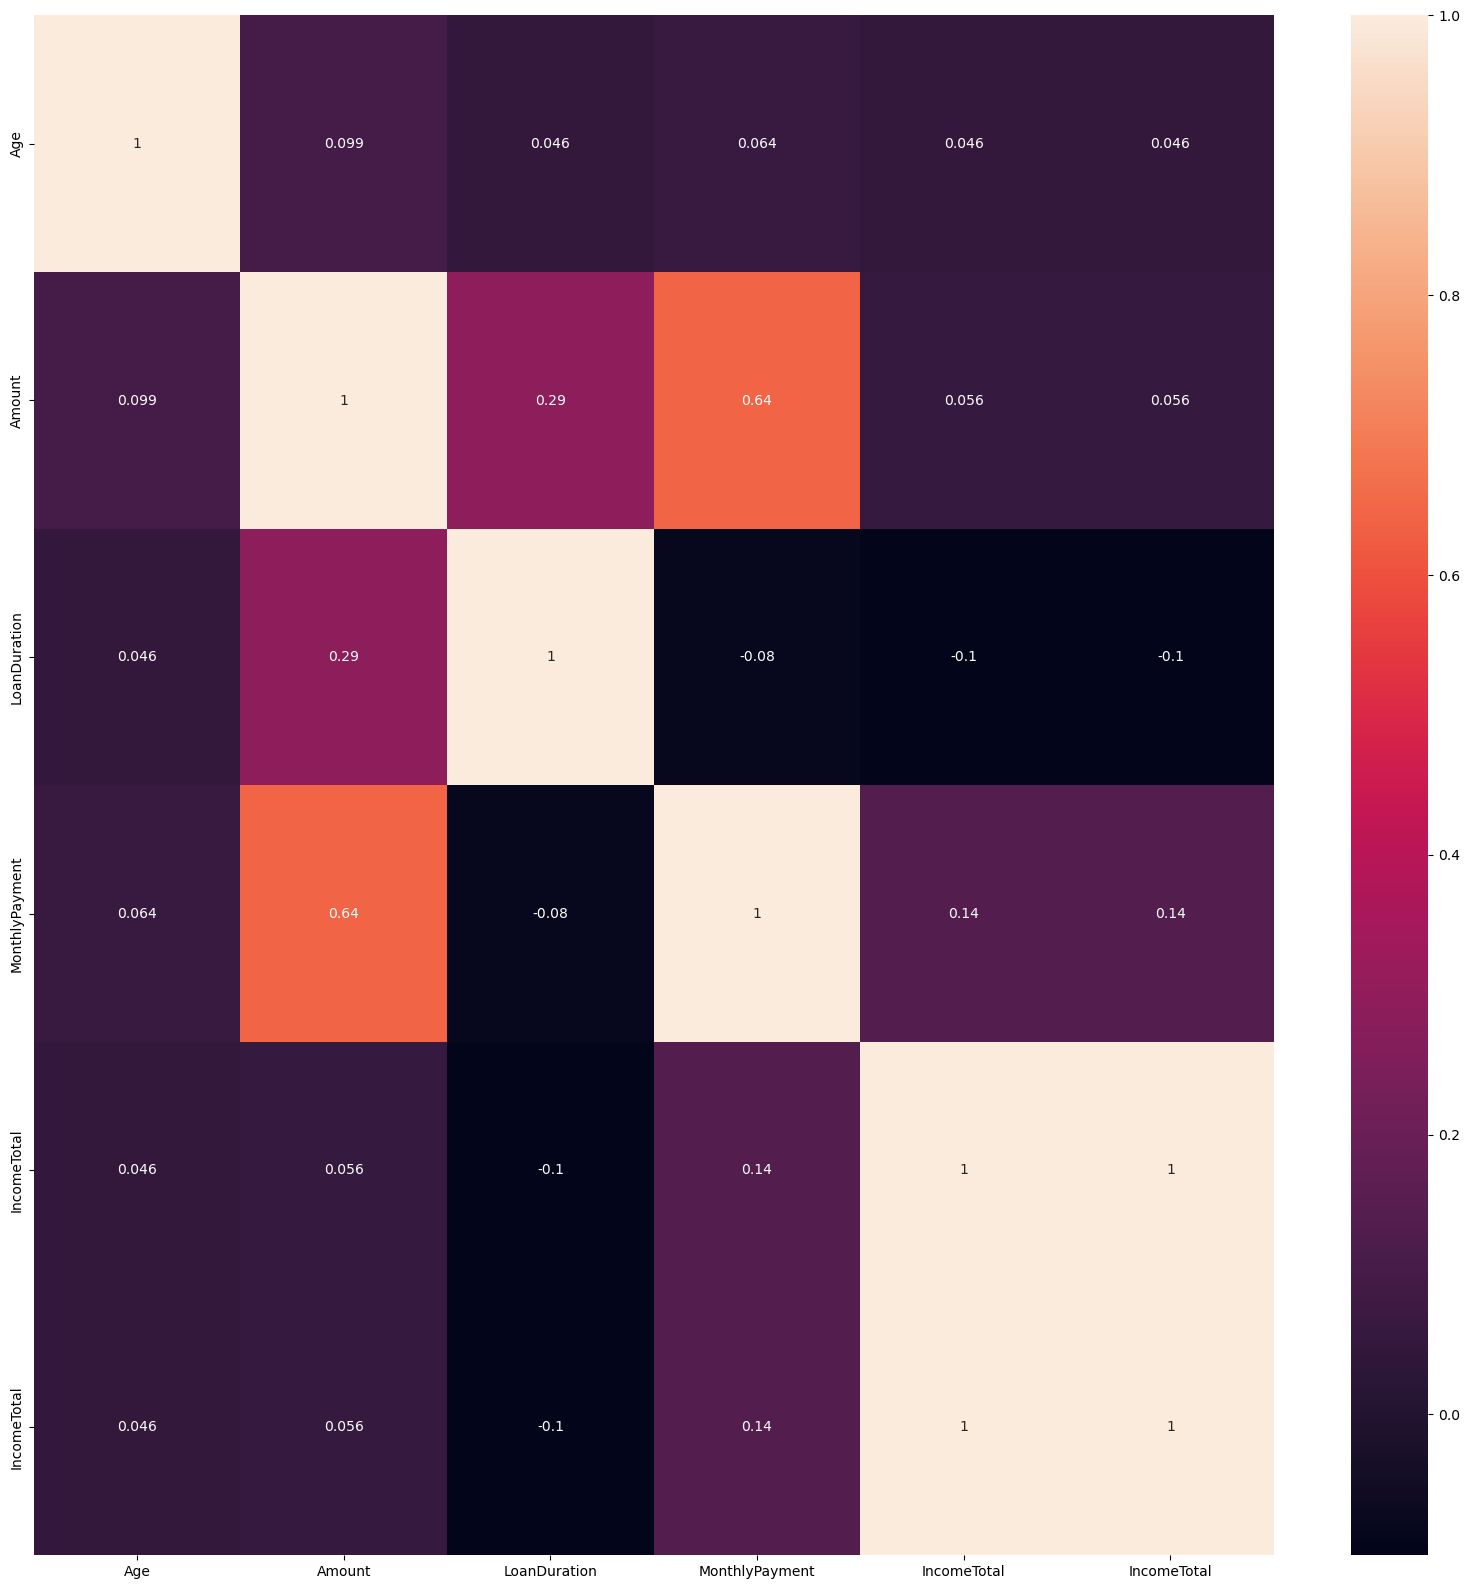

In [229]:
# Plot correlation matrix using Pearson coefficient
plt.figure(figsize=(20,20))
sns.heatmap(dulieuktl1_train.corr(method='pearson'), annot=True);

=> It is obvious that pairs of 2 variables in 'customers_income' , 'net_income' and 'total_income' have such a high correlation coefficient. I will keep only 'customers_income' in the short list for MFA cause it has the highest IV and gini values.

In [33]:
dulieuktl3_train = dulieuktl2_train.drop(columns=['net_income','total_income'])

#Note: 
I intended to run logistic regression between each variable in the short list and the target y.
Futhermore, the regression is not against the input, but rather against the WOE of each grouping created in the previous step. 
So there must have been some code lines where you can see me transform inputs into corresponding WOE values (Stage 3: Variables transformation)
These WOE values can be regarded as "score" of each attribute of each variable though they should be standardized so that comparing
characteristics together become easier and more intuitive (i.e all scores are transformed to have the same mean 0 and standard deviation 1, 
then scaling process can return score interval like [-100;100])
After all, I can examine sign of coefficients, p-values undertake T-test on the output table to be confident that all variables in the shortlist
are satified to run MFA.

In multiple factor analysis stage, Stepwise regression would be employed, numbers of combinations of variables would be analyzed based on list of criteria
including: p-values, models AR, business meaning,... to gain the best combination. This final model does best in predicting the default probability of customers.

However, this time I will try Scorecard package to help

In [50]:
dulieuktl1_train

ReportAsOfEOD        LoanId  LoanNumber  ListedOnUTC  \
0        2.220446e-16  2.220446e-16    1.662271     8.820652   
1        2.220446e-16  2.220446e-16   -0.048266    -6.113270   
2        2.220446e-16  2.220446e-16   -0.048266     8.820652   
3        2.220446e-16  2.220446e-16   -0.507730     8.820652   
4        2.220446e-16  2.220446e-16   -0.298035     8.820652   
...               ...           ...         ...          ...   
162315   2.220446e-16  2.220446e-16   -0.298035    -6.113270   
162316   2.220446e-16  2.220446e-16   -0.507730     8.820652   
162317   2.220446e-16  2.220446e-16   -0.048266     8.820652   
162318   2.220446e-16  2.220446e-16   -0.048266    -6.113270   
162319   2.220446e-16  2.220446e-16   -0.298035     8.820652   

        BiddingStartedOn  BidsPortfolioManager  BidsManual   PartyId  \
0               8.926013              0.000000   -0.074972  3.857705   
1              -6.113285              0.339317    0.459752 -5.693011   
2               8.926013              0.098439    0.000000 -0.837327   
3               8.926013             -0.256422   -0.331832  3.857705   
4               8.926013             -0.121149    0.000000  3.857705   
...                  ...                   ...         ...       ...   
162315         -6.113285              0.098439   -0.146362 -0.837327   
162316          8.926013             -0.273710   -0.074972  3.857705   
162317          8.926013             -0.256422   -0.074972  3.857705   
162318         -6.113285             -0.256422   -0.292613 -5.693011   
162319          8.926013              0.098439    0.091396  3.857705   

        NewCreditCustomer  LoanApplicationStartedDate  ...  \
0                0.063937                    8.484466  ...   
1                0.063937                   -6.251539  ...   
2               -0.045652                    8.484466  ...   
3                0.063937                    8.484466  ...   
4                0.063937                    8.484466  ...   
...                   ...                         ...  ...   
162315          -0.045652                   -6.251539  ...   
162316           0.063937                    8.484466  ...   
162317           0.063937                    8.484466  ...   
162318          -0.045652                   -6.251539  ...   
162319           0.063937                    8.484466  ...   

        PrincipalPaymentsMade  InterestAndPenaltyPaymentsMade  \
0                    0.528548                        0.357721   
1                    1.446159                       -0.186857   
2                    0.528548                        0.357721   
3                    2.777431                       -0.186857   
4                    0.528548                       -0.176815   
...                       ...                             ...   
162315               2.777431                       -0.186857   
162316               0.528548                       -0.004017   
162317               0.528548                       -0.176815   
162318              -0.729809                       -0.186857   
162319               2.777431                       -0.186857   

        PrincipalBalance  InterestAndPenaltyBalance  \
0               0.000000                   0.000000   
1              -9.582645                   0.000000   
2               0.000000                   0.000000   
3               0.000000                   0.000000   
4               0.000000                   0.000000   
...                  ...                        ...   
162315        -10.884992                  -0.989366   
162316          0.000000                  -0.577880   
162317          0.000000                   0.000000   
162318         -9.582645                   0.000000   
162319          0.000000                   0.000000   

        NoOfPreviousLoansBeforeLoan  AmountOfPreviousLoansBeforeLoan  \
0                          0.207297                        -0.165964   
1                         -0.058536        

In [69]:
dulieuktl1_train['y'] = dulieuktl1_train['y'].astype('int64')

In [64]:
y_train

371     1
5101    0
4139    0
1919    0
4194    0
       ..
3772    0
5191    0
5226    0
5390    0
860     0
Name: y, Length: 5788, dtype: category
Categories (2, int64): [0, 1]

In [20]:
dulieuktl1_train['y'] = dulieuktl1_train['y'].astype('int64')

In [304]:
finalvar = dulieuktl1_train[['NewCreditCustomer','MonthlyPayment','Amount','MaturityDate_Original','Country','LossGivenDefault','PlannedInterestTillDate']]
finalvar               

NewCreditCustomer  MonthlyPayment    Amount  MaturityDate_Original  \
85761            0.063680        0.240091  0.363145               0.374654   
43879            0.063680       -0.419314 -0.189870               0.374654   
127137          -0.045462        0.240091  0.363145               0.374654   
100658          -0.045462        0.240091  0.363145              -0.105993   
18042           -0.045462       -0.296480 -0.248736               0.374654   
...                   ...             ...       ...                    ...   
119879          -0.045462       -0.419314 -0.189870              -0.567048   
103694           0.063680        0.240091  0.231660               0.374654   
131932           0.063680        0.021877  0.363145              -0.567048   
146867          -0.045462       -0.296480 -0.189870              -0.567048   
121958           0.063680       -0.296480 -0.248736              -0.105993   

         Country  LossGivenDefault  PlannedInterestTillDate  
85761   0.441145         -0.306645                 0.162067  
43879   0.441145          0.259533                 0.867074  
127137  0.441145         -0.306645                 0.162067  
100658 -0.991125         -0.306645                 0.162067  
18042  -0.267300         -0.319133                 0.162067  
...          ...               ...                      ...  
119879  0.441145         -0.306645                 0.867074  
103694  0.441145         -0.306645                 0.162067  
131932  0.441145         -0.306645                 0.162067  
146867  0.441145          0.259533                -1.419466  
121958 -0.267300         -0.306645                 0.867074  

[162315 rows x 7 columns]

In [307]:
finalvarArray = ['NewCreditCustomer','MonthlyPayment','Amount','MaturityDate_Original','Country','LossGivenDefault','PlannedInterestTillDate']

In [305]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

logreg = LogisticRegression()
logreg.fit(finalvar, y_train)


LogisticRegression()

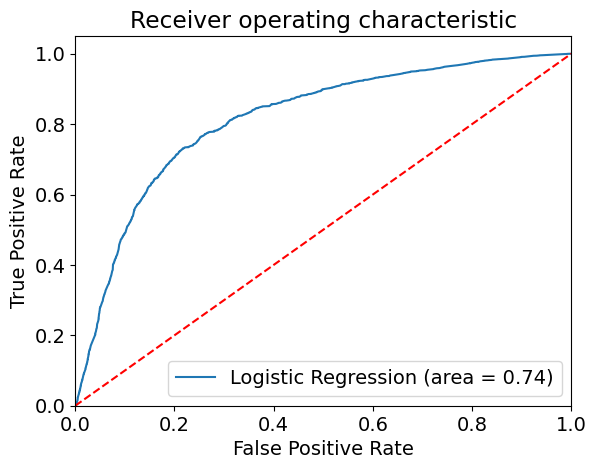

In [308]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(dulieuktl1_test[finalvarArray]))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(dulieuktl1_test[finalvarArray])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [267]:
dulieuktl1_train.loc[:, dulieuktl1_train.columns!='y']

Age    Amount  LoanDuration  MonthlyPayment  Education  \
0       0.076194  0.361852      1.719743        0.000000   0.117448   
1       0.194154 -0.188798     -0.312034       -0.412371   0.117448   
2       0.164942  0.230607     -0.312034        0.249390   0.117448   
3      -0.019556 -0.188798     -0.312034       -0.312136  -0.156750   
4      -0.433645  0.230607      0.984722        0.011855   0.117448   
...          ...       ...           ...             ...        ...   
162315  0.194154 -0.188798     -0.074556       -0.412371  -0.156750   
162316 -0.019556  0.230607      0.110131        0.249390   0.191275   
162317  0.039463  0.361852     -0.074556        0.011855  -0.156750   
162318  0.164942 -0.188798     -0.312034       -0.312136   0.117448   
162319 -0.174862 -0.250777      0.110131       -0.312136  -0.156750   

        MaritalStatus  EmploymentStatus  OccupationArea  HomeOwnershipType  \
0            0.924011          0.814963        1.080440           0.314353   
1           -0.141464         -0.140281       -0.129976          -0.253874   
2           -0.141464         -0.140281       -0.129976           0.148246   
3           -0.141464         -0.140281       -0.129976           0.314353   
4           -0.141464         -0.140281       -0.129976          -0.300716   
...               ...               ...             ...                ...   
162315      -0.141464         -0.140281       -0.129976          -0.077654   
162316      -0.141464         -0.140281       -0.129976           0.148246   
162317      -0.141464         -0.140281       -0.129976          -0.253874   
162318      -0.141464         -0.140281       -0.129976           0.148246   
162319      -0.141464         -0.140281       -0.129976           0.314353   

        IncomeTotal  
0          0.038976  
1          0.171018  
2         -0.134010  
3         -0.227103  
4         -0.077013  
...             ...  
162315    -0.134010  
162316     0.038976  
162317    -0.151956  
162318    -0.134010  
162319    -0.113663  

[162320 rows x 10 columns]

In [291]:
dulieuktl1_test = dulieuktl1_test.loc[:,~dulieuktl1_test.columns.duplicated()].copy()

In [279]:
dulieuktl1_test

y   Age     Amount  LoanDuration  MonthlyPayment Education  \
15922   1  28.0  3000.0000          36.0          129.62       5.0   
35788   0  34.0  5820.0000          36.0          301.87       5.0   
18120   0  50.0  3000.0000          60.0           92.45       2.0   
4816    0  46.0    95.8675           3.0             NaN       5.0   
104112  0  35.0   530.0000           9.0           66.59       5.0   
...    ..   ...        ...           ...             ...       ...   
58851   0  68.0  3185.0000          36.0          116.68       4.0   
281124  0  52.0  4146.0000          60.0          108.17       3.0   
85994   1  56.0  4250.0000          60.0          237.84       1.0   
17552   1  44.0  1000.0000          60.0           32.51       5.0   
239705  0  30.0  3632.0000          60.0           94.76       5.0   

       MaritalStatus EmploymentStatus OccupationArea HomeOwnershipType  \
15922            3.0              3.0           13.0               2.0   
35788            1.0              3.0            1.0               3.0   
18120            4.0              3.0            1.0               3.0   
4816             2.0              3.0            1.0               NaN   
104112          -1.0             -1.0           -1.0               2.0   
...              ...              ...            ...               ...   
58851           -1.0             -1.0           -1.0               1.0   
281124          -1.0             -1.0           -1.0               1.0   
85994           -1.0             -1.0           -1.0               3.0   
17552            1.0              6.0            1.0               1.0   
239705          -1.0             -1.0           -1.0               3.0   

        IncomeTotal  
15922        1019.0  
35788         700.0  
18120        2500.0  
4816        12800.0  
104112        700.0  
...             ...  
58851        1076.0  
281124       2600.0  
85994        1700.0  
17552        1348.0  
239705       2536.0  

[40580 rows x 11 columns]

In [293]:
dulieuktl1_test.loc[:, dulieuktl1_test.columns!='y'].replace(np.nan,0, inplace=True) 

C:\Users\HANG\AppData\Local\Temp\ipykernel_1172\401206700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dulieuktl1_test.loc[:, dulieuktl1_test.columns!='y'].replace(np.nan,0, inplace=True)


In [299]:
y_test = pd.to_numeric(y_test, errors='coerce')

In [297]:
dulieuktl1_test = dulieuktl1_test.fillna(dulieuktl1_test.mode().iloc[0])

In [301]:
dulieuktl1_test.loc[:, dulieuktl1_test.columns!='y']

Age     Amount  LoanDuration  MonthlyPayment  Education  \
15922   28.0  3000.0000          36.0          129.62        5.0   
35788   34.0  5820.0000          36.0          301.87        5.0   
18120   50.0  3000.0000          60.0           92.45        2.0   
4816    46.0    95.8675           3.0          108.27        5.0   
104112  35.0   530.0000           9.0           66.59        5.0   
...      ...        ...           ...             ...        ...   
58851   68.0  3185.0000          36.0          116.68        4.0   
281124  52.0  4146.0000          60.0          108.17        3.0   
85994   56.0  4250.0000          60.0          237.84        1.0   
17552   44.0  1000.0000          60.0           32.51        5.0   
239705  30.0  3632.0000          60.0           94.76        5.0   

        MaritalStatus  EmploymentStatus  OccupationArea  HomeOwnershipType  \
15922             3.0               3.0            13.0                2.0   
35788             1.0               3.0             1.0                3.0   
18120             4.0               3.0             1.0                3.0   
4816              2.0               3.0             1.0                1.0   
104112           -1.0              -1.0            -1.0                2.0   
...               ...               ...             ...                ...   
58851            -1.0              -1.0            -1.0                1.0   
281124           -1.0              -1.0            -1.0                1.0   
85994            -1.0              -1.0            -1.0                3.0   
17552             1.0               6.0             1.0                1.0   
239705           -1.0              -1.0            -1.0                3.0   

        IncomeTotal  
15922        1019.0  
35788         700.0  
18120        2500.0  
4816        12800.0  
104112        700.0  
...             ...  
58851        1076.0  
281124       2600.0  
85994        1700.0  
17552        1348.0  
239705       2536.0  

[40580 rows x 10 columns]

In [340]:
y_test.shape

(40580,)

In [343]:
logreg.predict_proba(dulieuktl1_test.loc[:, dulieuktl1_test.columns!='y'])[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

In [163]:
np.count_nonzero(y_train == 1)

384

In [187]:
list = ['total_income', 'loan_amount']
i = range(0,len(list)-1)
i

range(0, 1)

In [101]:
from sklearn import preprocessing

In [129]:
dulieuktl1_train = preprocessing.scale(dulieuktl1_train)

In [147]:
dulieuktl1_train.iloc[:] = dulieuktl1_train.iloc[:]*100

In [134]:
columns = dulieuktl.drop(dulieuktl.columns[[9,15,18,20,21,26,36,38,40,46]], axis = 1).columns.values

In [149]:
dulieuktl1_train.drop('default_prob',axis = 1)

y    areaname      gender  education  marital_status  \
0      97.635490  167.843008   92.662970 -30.190377      -41.501430   
1     -99.394760  -60.049865  -99.517230 -30.190377      -41.501430   
2     106.827829  -60.049865  137.193655 -30.190377      -41.501430   
3     -99.394760  -60.049865   92.662970 -30.190377      -41.501430   
4     106.827829  -60.049865   92.662970 -30.190377      -41.501430   
...          ...         ...         ...        ...             ...   
5783  -99.394760  -60.049865  137.193655 -30.190377      -41.501430   
5784  106.827829  -60.049865  137.193655 -30.190377      -41.501430   
5785  -99.394760  -60.049865  137.193655 -30.190377      -41.501430   
5786   97.635490  167.843008   92.662970 -30.190377      242.607973   
5787  -99.394760  -60.049865  -99.517230 -30.190377      -41.501430   

      residential_status  occupation  employment_type  salary_account_flag  \
0              69.833726   51.107164        23.817108            33.537528   
1            -289.579411 -174.320702        23.817108            33.537528   
2              69.833726  123.078083        23.817108            33.537528   
3              69.833726   51.107164        23.817108            33.537528   
4              69.833726   51.107164        23.817108            33.537528   
...                  ...         ...              ...                  ...   
5783            8.900148 -174.320702        23.817108          -298.225431   
5784           69.833726   51.107164        23.817108            33.537528   
5785           69.833726   51.107164        23.817108            33.537528   
5786           69.833726  123.078083        23.817108            33.537528   
5787          -29.885934  -64.711471      -423.183109            33.537528   

      collateral_type  ...  downpayment_ratio  loan_to_collateral_value  \
0          -41.288646  ...           9.619462                 30.936883   
1          -41.288646  ...           9.619462                -55.901658   
2          -41.288646  ...           9.619462                 38.758277   
3          -41.288646  ...           9.619462                -23.700362   
4          -41.288646  ...           9.619462                 30.936883   
...               ...  ...                ...                       ...   
5783       -41.288646  ...        -384.889524                 83.529456   
5784       -41.288646  ...           9.619462                 43.992964   
5785       -41.288646  ...           9.619462                -55.901658   
5786       -41.288646  ...           9.619462                -55.901658   
5787       -41.288646  ...           9.619462                 43.992964   

      expense_to_income  loan_to_income  loan_requested_to_income        ltv  \
0           -173.597221     -291.116430                 50.815022  47.342821   
1             49.760744       -5.535230                 50.815022  47.342821   
2             54.265101       90.726749                 44.743572  47.342821   
3             49.760744       -5.535230                -52.139435  47.342821   
4             54.265101       -5.535230               -129.602638  47.342821   
...                 ...             ...                       ...        ...   
5783          49.760744       -5.535230               -129.602638  47.342821   
5784          49.760744       -5.535230                 44.743572 -88.836098   
5785          49.760744       -5.535230                -52.139435  47.342821   
5786          16.062820       90.726749                 50.815022  47.342821   
5787          16.062820       -5.535230               -334.507416  47.342821   

      loan_expense_to_main_income  loan_to_main_income  \
0                       18.955676            22.752756   
1                       50.851912            22.752756   
2                       17.004851            22.463641   
3                       50.851912           -82.403151   
4                       17.004851           -82.403151   
...            

In [103]:
# Define the feature list from dataset (including categorical and numerical)
list_features = dulieuktl3_train.drop(columns=['y']).columns.values

# Define categorical features list
list_categorical = dulieuktl3_train.drop(columns=['y']).select_dtypes(include=['object', 'category']).columns.values

# Instatiate BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features
    )

# Define logisticRegression method
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161)

# Define scaling method and values
'khong co tai lieu nao nhac den min_max la sao'
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 100}

# Instatiate and fit Scorecard
scorecard = Scorecard(
 
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=False,
    reverse_scorecard=True
    )

scorecard.fit(dulieuktl3_train.drop(columns=['y']),y_train)

scorecard_summary = scorecard.table(style="detailed").round(3)

In [100]:
print(scorecard_summary.to_string())

                    Variable  Bin id                                                                                                                                                                  Bin  Count  Count (%)  Non-event  Event  Event rate    WoE     IV     JS  Coefficient  Points
0                   areaname       0                                                                                                                                                           [Northern]   2900      0.501       2771    129       0.044  0.423  0.075  0.009       -0.774   9.173
1                   areaname       1                                                                                                                                                           [Southern]   1667      0.288       1519    148       0.089 -0.316  0.033  0.004       -0.774  -0.907
2                   areaname       2                                                                                        

5. Model validation

Finally, I can visualize my Scorecard performance using functions from optbinning.scorecard.plots module.

In [276]:
from optbinning.scorecard.plots import plot_ks, plot_auc_roc

# Assign score and predicted probability to test dataset
dulieuktl1_test.loc[:,"score"] = scorecard.score(dulieuktl1_test)

# Kolmogorov_Smirnov Plot
plot_ks(dulieuktl1_test.y, dulieuktl1_test.score)

NameError: name 'scorecard' is not defined

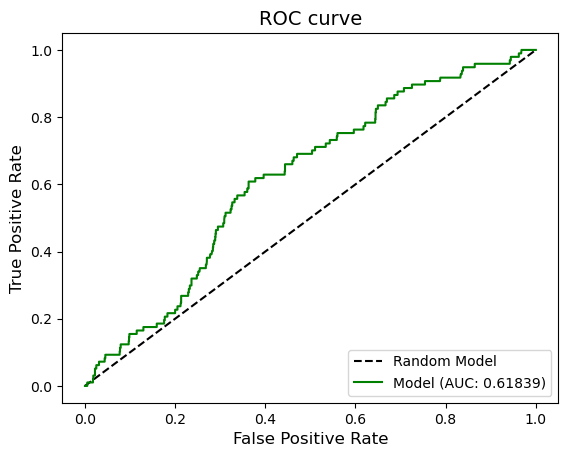

In [119]:
# ROC-AUC plot
plot_auc_roc(dulieuktl1_test.y, dulieuktl1_test.score)

The Kolmogorov_Smirnov Plot seems kind of weird (honestly, strange to me), so I need more time to think about it!
Anyway, this is the end of my project. Thanks for watching!

In [ ]:
variable_names = dulieuktl1_train.columns.values
categorical_variables = dulieuktl1_train.select_dtypes(include = ["category","object"]).columns.values

X = dulieuktl1_train[np.delete(variable_names,y)]
y = dulieuktl1_train["y"].values

binning_process = BinningProcess(np.delete(variable_names,y),
                                 categorical_variables=np.delete(categorical_variables,y)
                                )

binning_process.fit(X, y)